## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

Running 12760 CDFs


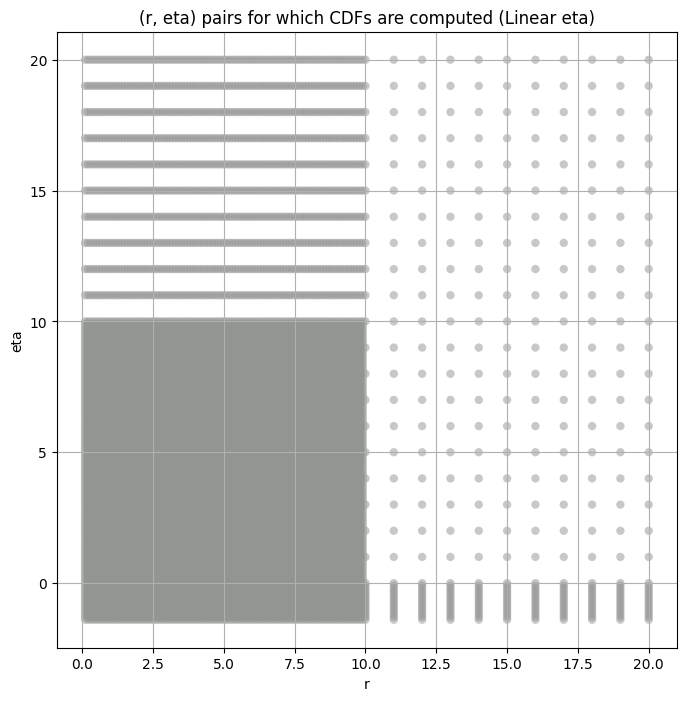

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 32


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     12.612577  11.997124  13.256687   1.683772    1.216708    2.278544   
5      6.771047   6.442859   7.115182   1.673940    1.145577    2.416164   
8      3.703258   3.524485   3.887768   1.670122    1.185903    2.265765   
11     2.096400   1.990466   2.207998   2.008084    1.229830    3.563033   
14     1.138359   1.082433   1.197961   1.909717    1.181973    3.535631   
17     0.632978   0.601389   0.666091   1.925273    1.244871    3.354832   
20     0.316254   0.300020   0.334030   2.323948    1.348187    7.316415   
23     0.146715   0.139002   0.155042   2.512090    1.532273    5.086997   
26     0.058341   0.054549   0.063335   6.085310    2.217141   24.902412   
29     0.018184   0.016286   0.021421  26.047552    5.259968  114.970770   
32     0.001502   0.001426   0.001581   1.958381    1.283293    4.106231   

      total_samples  
band                 
2           31800.0  
5           41340.0  
8           66780.0  
11         104940.0  
14         162180.0  
17         257580.0  
20         381600.0  
23         610560.0  
26         973080.0  
29        1376940.0  
32         419760.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     12.612577      12.612577       12.162595       11.867589   
5      6.771047       6.771047        6.572597        6.447566   
8      3.703258       3.703258        3.627510        3.576439   
11     2.096400       2.096400        2.057527        2.034837   
14     1.138359       1.138359        1.118590        1.106618   
17     0.632978       0.632978        0.621841        0.615158   
20     0.316254       0.316254        0.310415        0.306982   
23     0.146715       0.146715        0.143753        0.142016   
26     0.058341       0.058341        0.056373        0.055480   
29     0.018184       0.018184        0.016814        0.016303   
32     0.001502       0.001502        0.001477        0.001461   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2          11.628742        11.422186        11.064171        10.752759   
5           6.341868         6.248390         6.083744         5.939867   
8           3.532765         3.494069         3.426132         3.366869   
11          2.015910         1.999305         1.969795         1.943470   
14          1.096395         1.087402         1.071617         1.057669   
17          0.609550         0.604531         0.595663         0.587818   
20          0.304100         0.301520         0.296908         0.292804   
23          0.140568         0.139284         0.137040         0.135071   
26          0.054781         0.054177         0.053143         0.052265   
29          0.015939         0.015655         0.015213         0.014867   
32          0.001447         0.001435         0.001413         0.001394   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2           10.475311        10.223770         9.990070         9.368567  
5            5.809677         5.689457         5.579109         5.284484  
8            3.313551         3.264468         3.218497         3.094078  
11           1.919371         1.897167         1.876383         1.820827  
14           1.044900         1.032995         1.021900         0.992169  
17           0.580640         0.573991         0.567770         0.551071  
20           0.289076         0.285652         0.282451         0.273806  
23           0.133298         0.131664         0.130140         0.126065  
26           0.051487         0.050783         0.050135         0.048427  
29           0.014576         0.014323         0.014097         0.013524  
32           0.001377         0.001361         0.001346         0.001306

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0037095419894010995 12.612577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0037552474364368482 12.162595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0037921783485823646 11.867589


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0042476736562071515 11.628742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0051427456840029695 11.422186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0070478317901029874 11.064171


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.009442231977397068 10.752759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.011648178670182613 10.475311


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.013741960220736628 10.22377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.015664157215851335 9.99007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.021233842746443188 9.368567
Number of samples: 31800, Without approximation : 31800.0


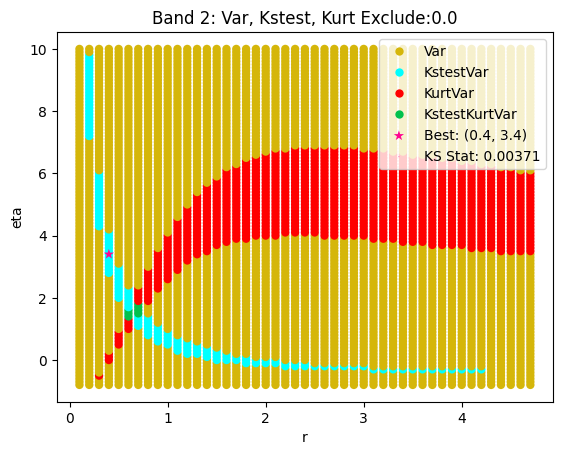

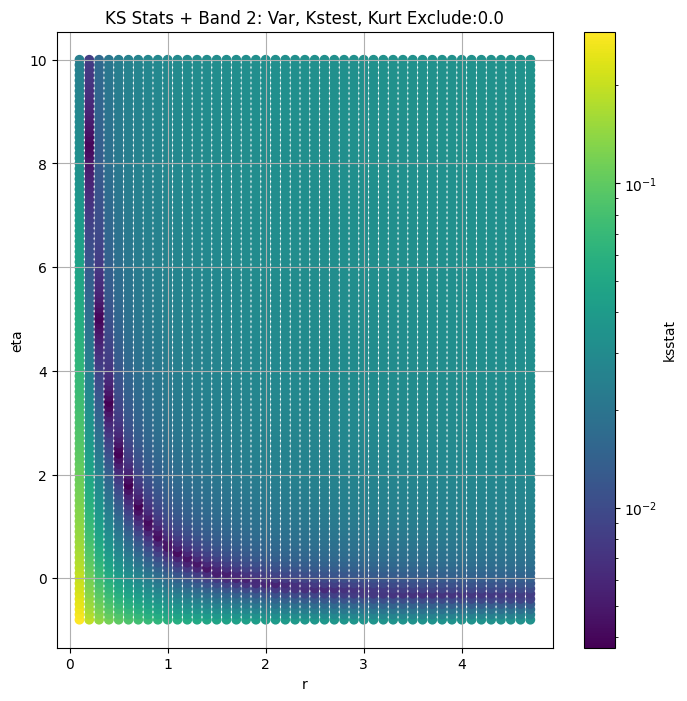

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0024297894020909594 6.7710466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.002314994459444303 6.572597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.002699471940534992 6.4475656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0033865436388807457 6.341868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.004042170087398045 6.24839


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0052767981098529315 6.083744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006554184287055009 5.9398675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.00806095692246711 5.8096766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.00983919554496343 5.689457


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.011363726622754089 5.5791087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.015803774880772573 5.2844844
Number of samples: 41340, Without approximation : 41340.0


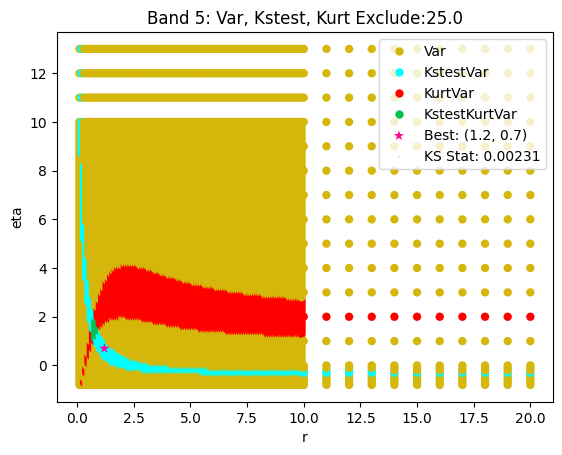

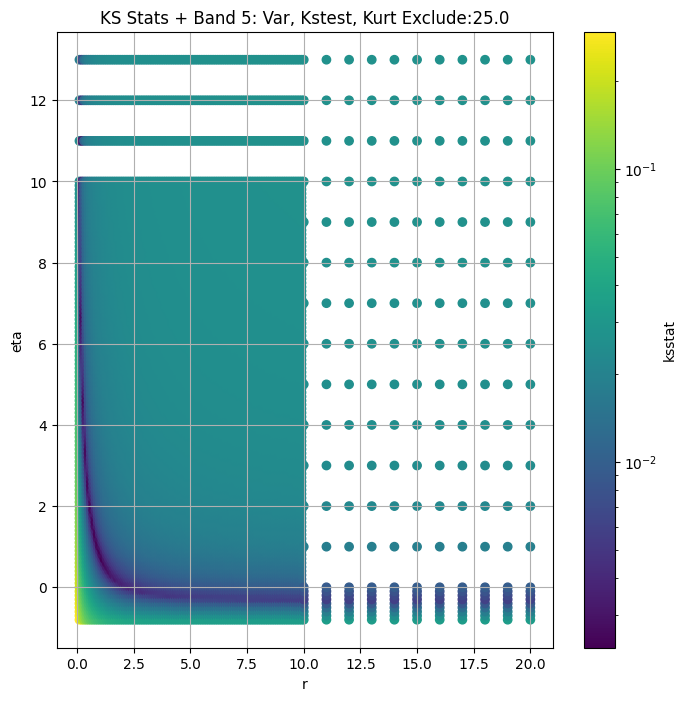

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0031025207006561972 3.7032576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0030833413184448988 3.62751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0030712829080603576 3.5764391


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0031127717366290497 3.5327654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0031964099157176795 3.494069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.003896926457110296 3.4261317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.004693544875066565 3.3668692


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00546010305348146 3.3135514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0061946492570952305 3.264468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007048435383158247 3.2184966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010204337878009229 3.0940778
Number of samples: 66780, Without approximation : 66780.0


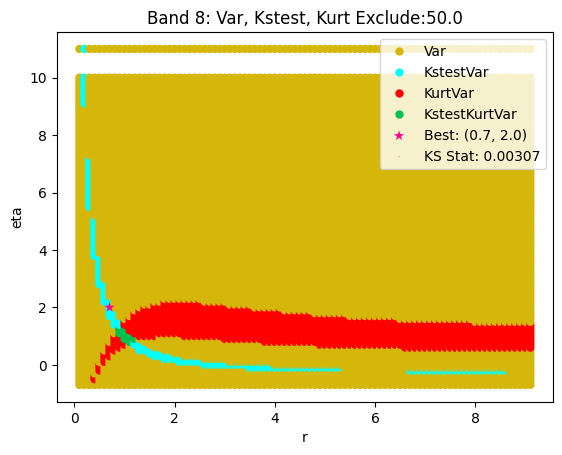

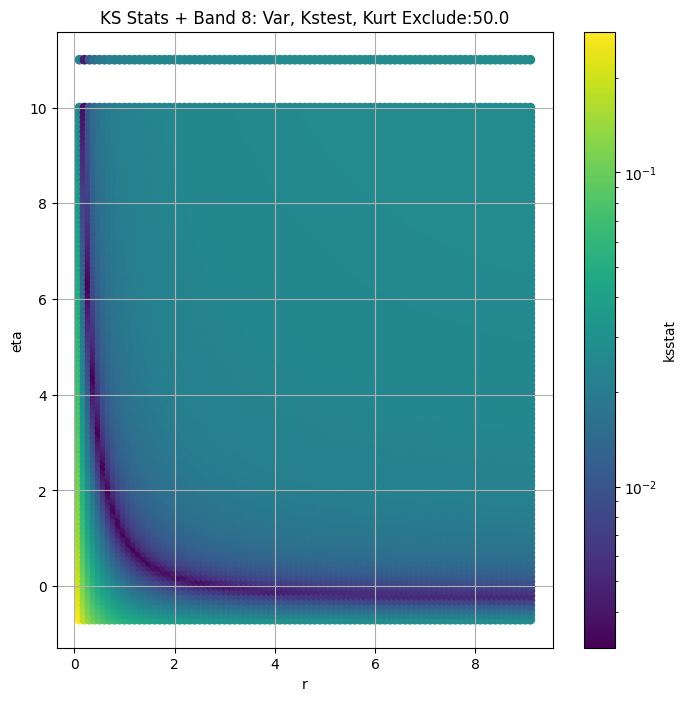

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.0017088921028226012 2.0963998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.0016725160599571076 2.0575273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0016979881334517333 2.0348365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0017806471693031511 2.0159101


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0019079235614033463 1.9993045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.002558397796606937 1.9697953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0032100519387178172 1.9434701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.0037761712224595456 1.9193715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.004341565568683814 1.8971666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.004865899172555088 1.8763826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.006589600344056541 1.8208265
Number of samples: 100000, Without approximation : 104940.0


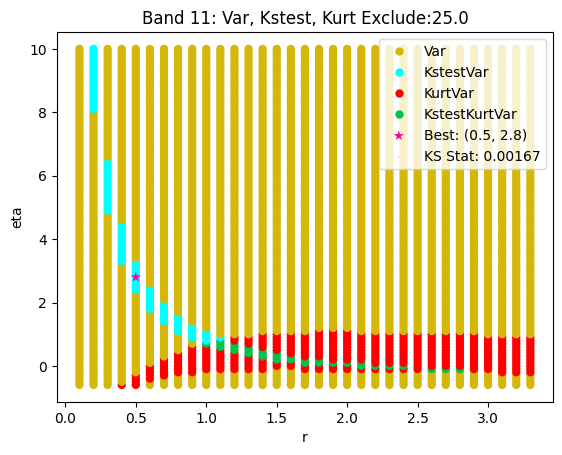

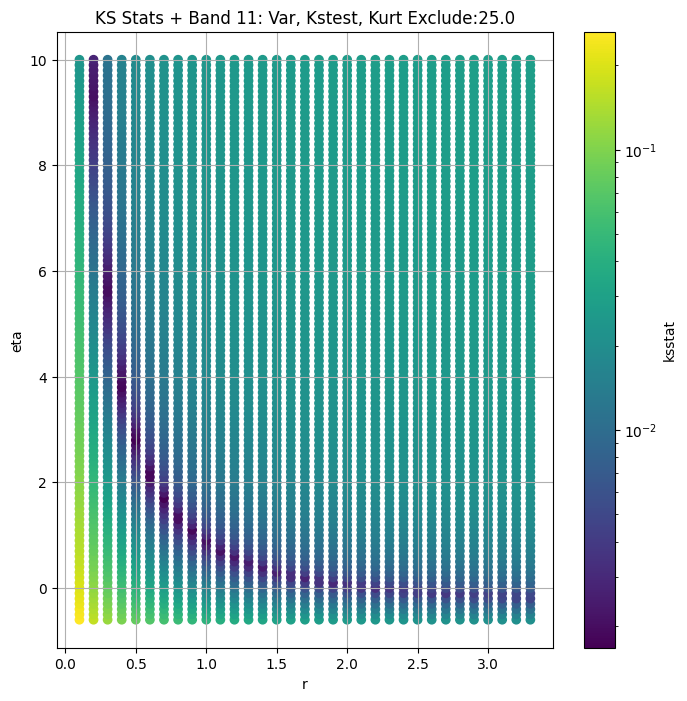

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0026196851858196757 1.1383592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.0026589312031083667 1.1185902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.0026947230902263364 1.1066183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.002567774944978063 1.0963951


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.002657169468058107 1.0874019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.0030210611565630874 1.071617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.0036011539212949806 1.0576692


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.004123384623273912 1.0449


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.004699006990237032 1.0329953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.005225754584378316 1.0218996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.006891090248577911 0.992169
Number of samples: 100000, Without approximation : 162180.0


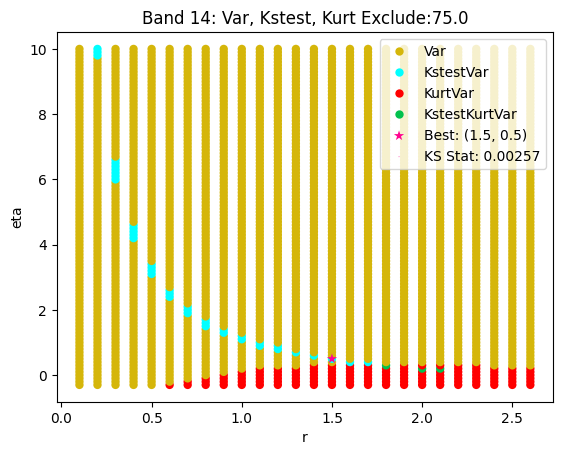

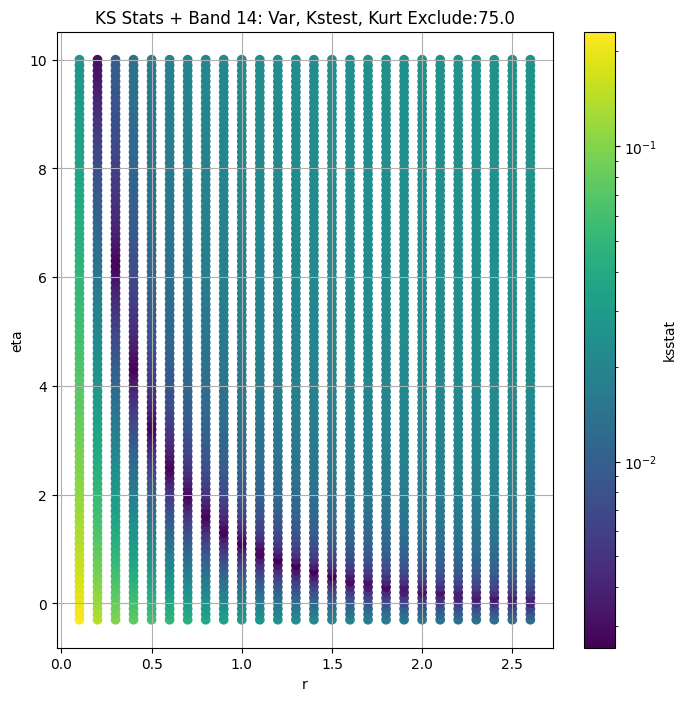

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.0007729102014857048 0.6329777


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.0010387230332811193 0.62184125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.0012429550006022028 0.61515844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.0016537310316562248 0.6095496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.001972904841407108 0.60453075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.0026048691048361494 0.5956627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.0032095111398853238 0.58781767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.003795849220340819 0.58064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.004454484127949354 0.5739911


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.005126078242044141 0.5677705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.0070446066481076874 0.551071
Number of samples: 100000, Without approximation : 257580.0


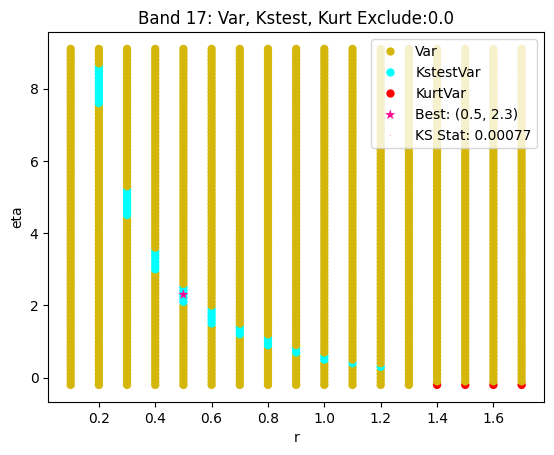

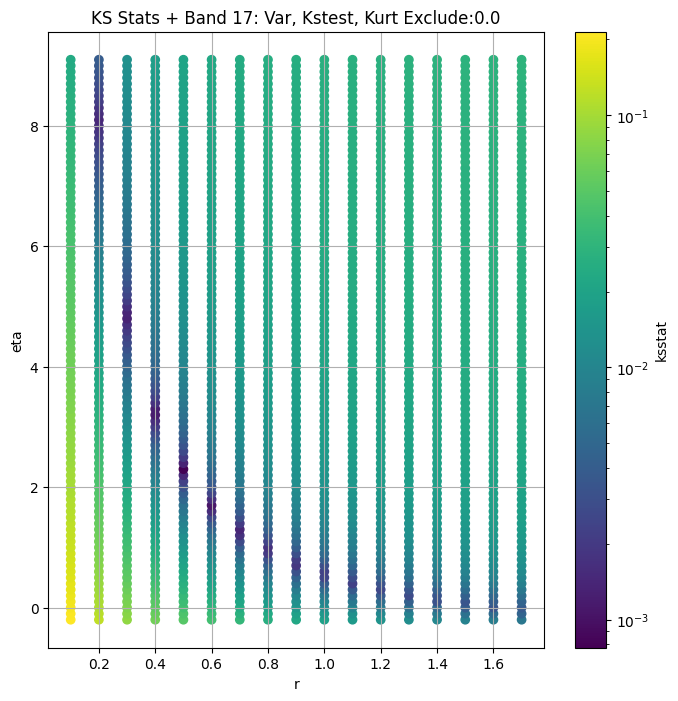

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0008106040121177438 0.31625372


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0007827850453913932 0.31041533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.001059169014484329 0.3069824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0013803490837910326 0.30409962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0017701258966301703 0.30152014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0023497454286519615 0.2969076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0030172612892223616 0.2928042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.00358193147829311 0.28907564


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.004165528516880679 0.2856517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.004729015647132462 0.2824511


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.0065021162450788275 0.27380607
Number of samples: 100000, Without approximation : 381600.0


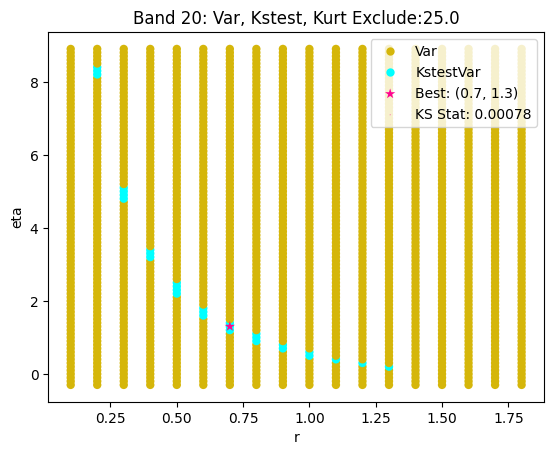

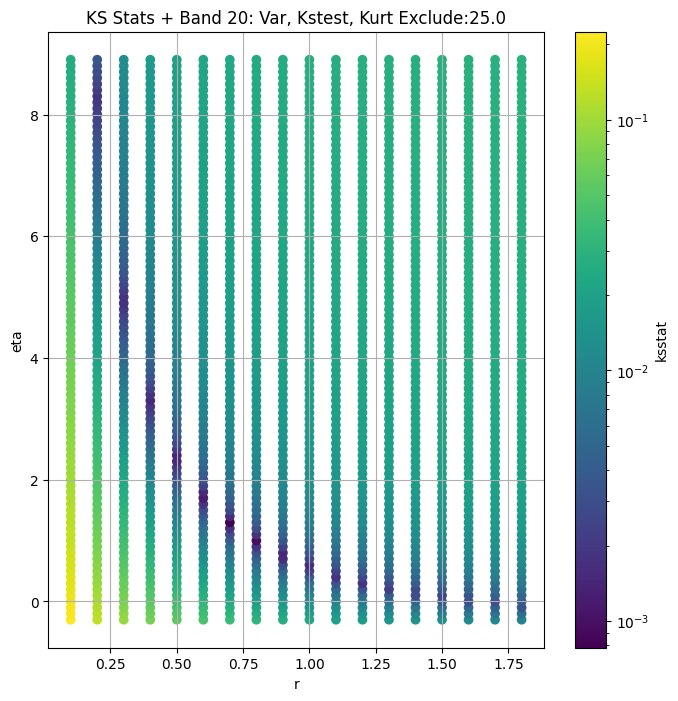

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0015308703147384611 0.1467151


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0014938239644785023 0.14375255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.001497998951891788 0.14201646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0015359014389990655 0.14056846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0018881728901681827 0.13928406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.002550632636594302 0.1370397


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0031801713737176322 0.13507059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.003759305987452794 0.13329841


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.004344125046902427 0.13166374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.0048873441131175935 0.13013993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.006492455243183648 0.12606451
Number of samples: 100000, Without approximation : 610560.0


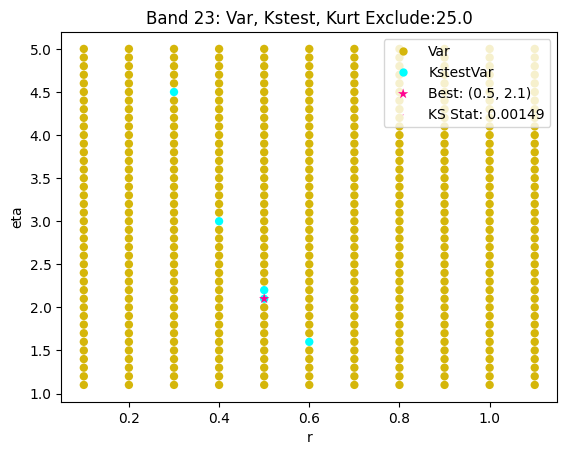

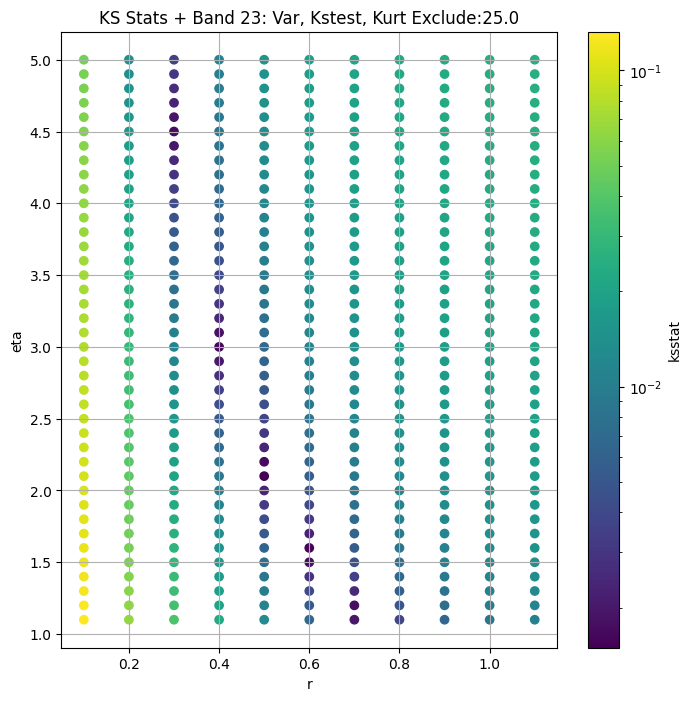

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.002099229929440366 0.05834127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0009452596949439673 0.056372855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0008588244962439706 0.055479567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0012767948109015936 0.054781344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0017120935180391372 0.054176595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0024081279332789363 0.053143077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.0030531390408824466 0.052264847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.0036879172198933663 0.051487014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.00425569457892494 0.05078289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.004814502572047741 0.0501346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.006456245961458218 0.048427463
Number of samples: 100000, Without approximation : 973080.0


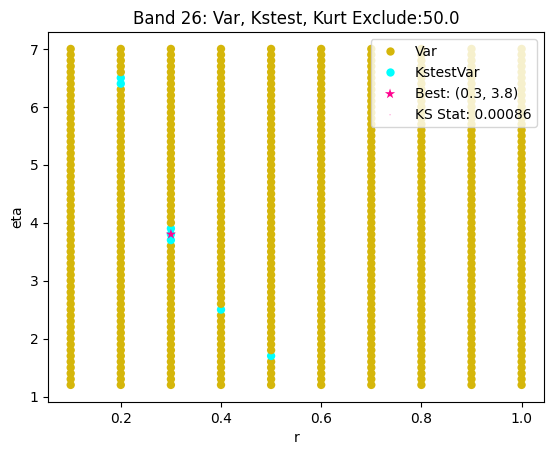

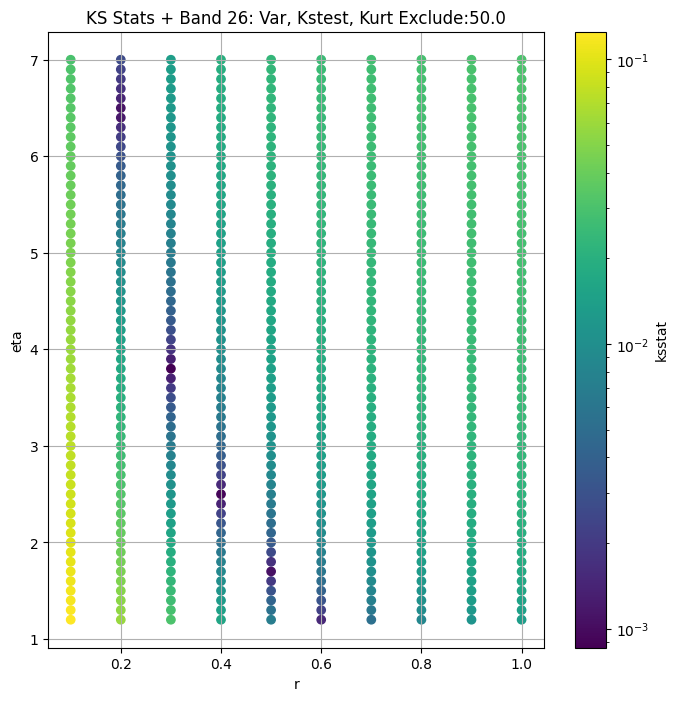

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.0070684759863338595 0.018183842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.00388461186026013 0.016813578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.0025477351095046785 0.016303293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.0015641391410212216 0.015939388


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.0017029013268126114 0.0156548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.0022146294124612 0.015212968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.002803054281163897 0.014866687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.00342878675600633 0.014576413


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.003993017486103589 0.014323082


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.004540746626260361 0.014096608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.006258217294220603 0.013524098
Number of samples: 100000, Without approximation : 1376940.0


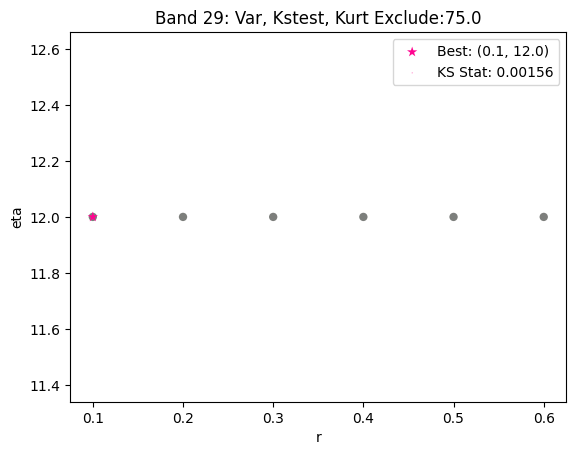

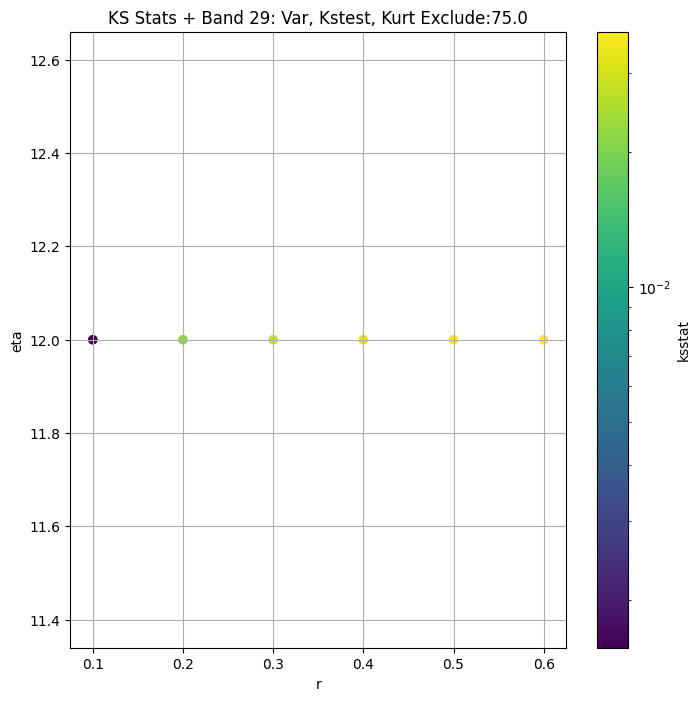

####
Band  32


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 0 0.0015653072222914233 0.0015016715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 25 0.0014780986586451772 0.0014767431


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 50 0.0016908198045378908 0.0014605683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 75 0.0018403445960540887 0.001446905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 100 0.002123559683321268 0.0014347126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 150 0.0027753460300781185 0.0014133211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 200 0.0034121871318412156 0.0013944545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 250 0.004034080398985285 0.0013772859


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 300 0.004597984610512654 0.0013613396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 350 0.005145569489775275 0.0013463232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 500 0.006902661598125366 0.0013060143
Number of samples: 100000, Without approximation : 419760.0


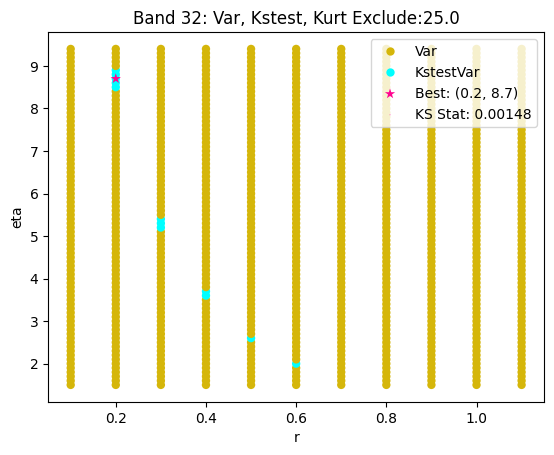

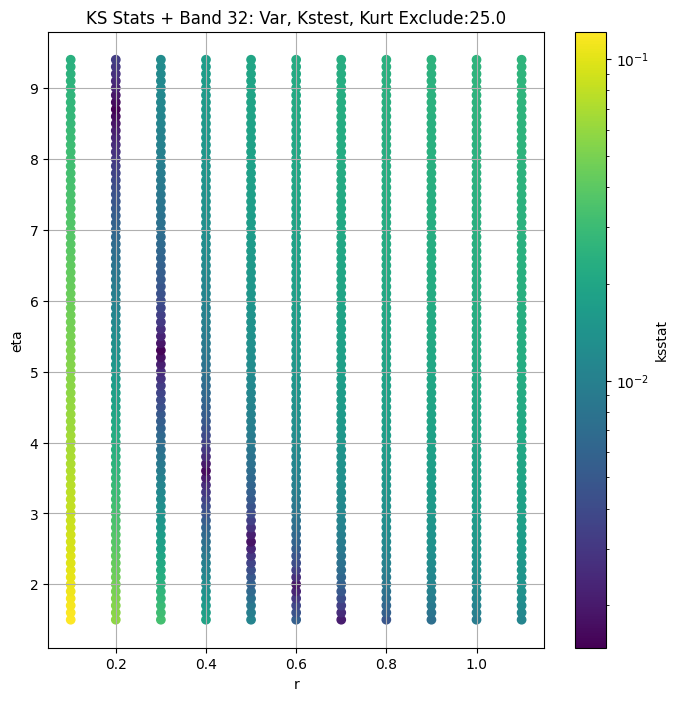

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     12.612577  11.997124  13.256687   1.683772    1.216708    2.278544   
5      6.771047   6.442859   7.115182   1.673940    1.145577    2.416164   
8      3.703258   3.524485   3.887768   1.670122    1.185903    2.265765   
11     2.096400   1.990466   2.207998   2.008084    1.229830    3.563033   
14     1.138359   1.082433   1.197961   1.909717    1.181973    3.535631   
17     0.632978   0.601389   0.666091   1.925273    1.244871    3.354832   
20     0.316254   0.300020   0.334030   2.323948    1.348187    7.316415   
23     0.146715   0.139002   0.155042   2.512090    1.532273    5.086997   
26     0.058341   0.054549   0.063335   6.085310    2.217141   24.902412   
29     0.018184   0.016286   0.021421  26.047552    5.259968  114.970770   
32     0.001502   0.001426   0.001581   1.958381    1.283293    4.106231   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           31800.0             0.003710        0.4          3.4   
5           41340.0             0.002315        1.2          0.7   
8           66780.0             0.003071        0.7          2.0   
11         104940.0             0.001673        0.5          2.8   
14         162180.0             0.002568        1.5          0.5   
17         257580.0             0.000773        0.5          2.3   
20         381600.0             0.000783        0.7          1.3   
23         610560.0             0.001494        0.5          2.1   
26         973080.0             0.000859        0.3          3.8   
29        1376940.0             0.001564        0.1         12.0   
32         419760.0             0.001478        0.2          8.7   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.076602e-02                     0.0           12.612577   
5      4.109167e+00                    25.0            6.572597   
8      3.387471e-01                    50.0            3.576439   
11     2.492160e-02                    25.0            2.057527   
14     9.790584e-01                    75.0            1.096395   
17     9.684482e-03                     0.0            0.632978   
20     3.990189e-02                    25.0            0.310415   
23     2.434833e-03                    25.0            0.143753   
26     3.133996e-06                    50.0            0.055480   
29     5.723353e-24                    75.0            0.015939   
32     3.537522e-12                    25.0            0.001477   

      kstest_stat_cutoff_0.05  
band                           
2                    0.007611  
5                    0.006675  
8                    0.005253  
11                   0.004191  
14                   0.003371  
17                   0.002675  
20                   0.002198  
23                   0.001738  
26                   0.001377  
29                   0.001157  
32                   0.002096

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.006908567494836676, var: 11.422185897827148


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.006081328101274708, var: 11.628742218017578


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.005270477143190247, var: 11.867588996887207


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.004431230217328441, var: 12.16259479522705


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.0037095419894010995, var: 12.612577438354492
Number of samples: 31800, Without approximation : 31800.0


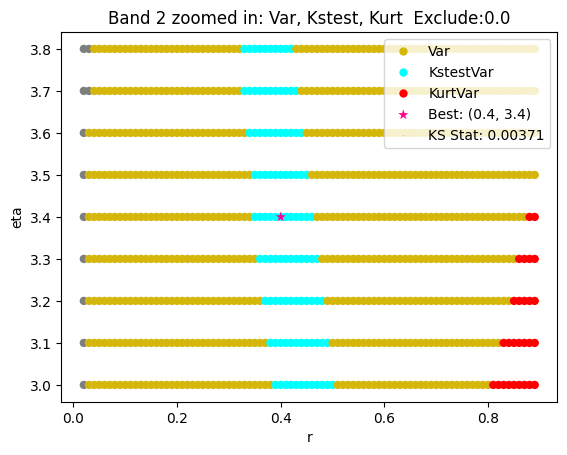

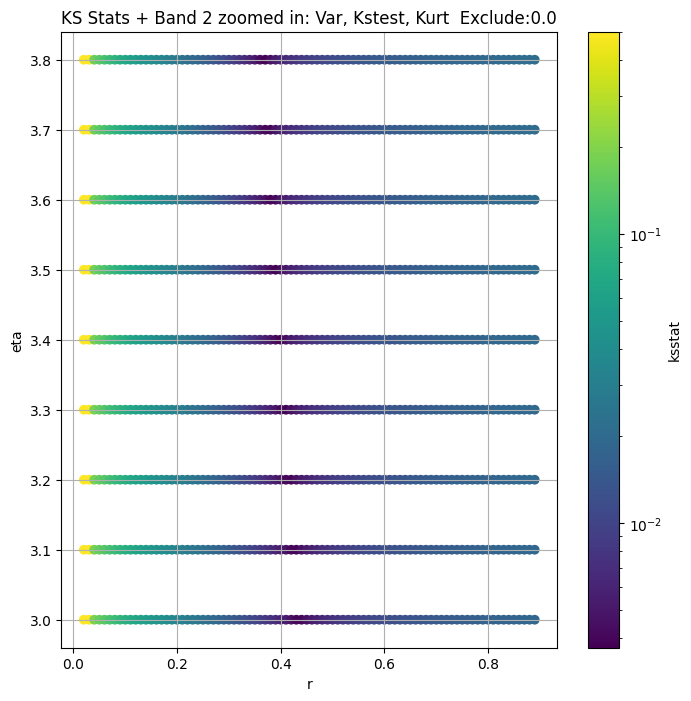

Band 5


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.00499181768813306, var: 6.1633405685424805


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.004133469357304853, var: 6.248390197753906


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.003365426863336629, var: 6.341867923736572


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.0026666679396200044, var: 6.44756555557251


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.0023105417270591344, var: 6.572597026824951


  0%|          | 0/990 [00:00<?, ?it/s]

Finding Minimum after computing 990 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.0030387980791645175, var: 6.7710466384887695
Number of samples: 41340, Without approximation : 41340.0


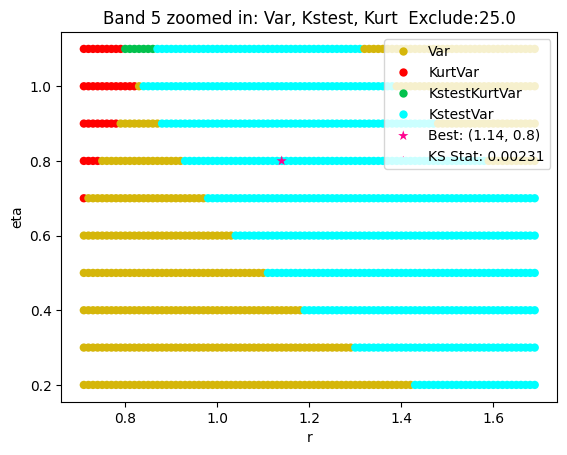

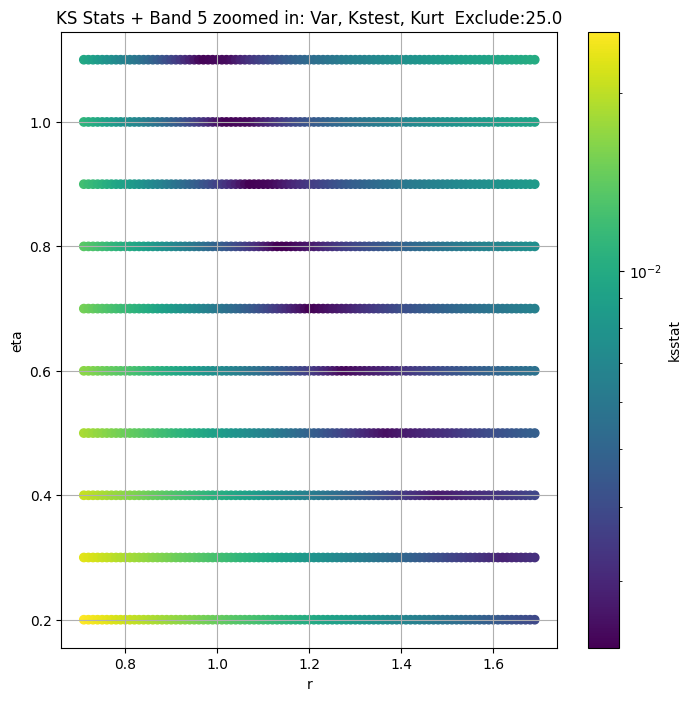

Band 8


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + 100 = 150, ksstat: 0.0041676167942491515, var: 3.4261317253112793


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + 75 = 125, ksstat: 0.003697467210908245, var: 3.45872163772583


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + 50 = 100, ksstat: 0.0032564873659011173, var: 3.4940690994262695


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + 25 = 75, ksstat: 0.0030646196797074476, var: 3.5327653884887695


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + 0 = 50, ksstat: 0.003060894441369477, var: 3.576439142227173


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + -25 = 25, ksstat: 0.003056572624265619, var: 3.6275100708007812


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 8, 50.0 + -50 = 0, ksstat: 0.003076282509834216, var: 3.7032575607299805
Number of samples: 66780, Without approximation : 66780.0


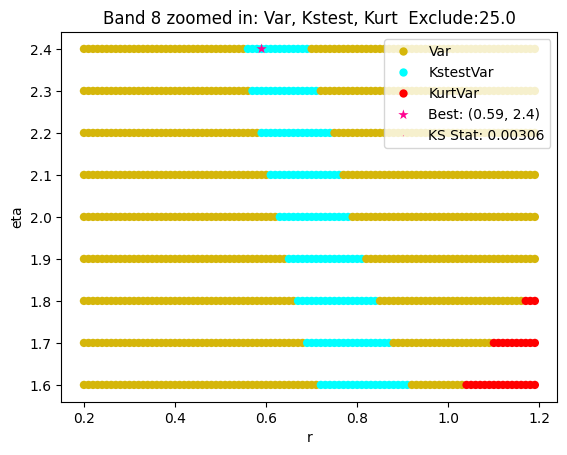

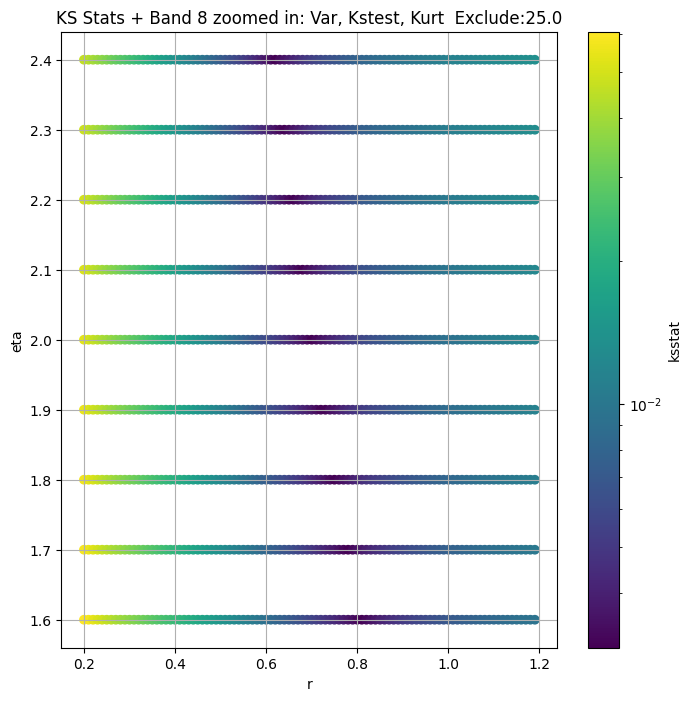

Band 11


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.0027689064292589632, var: 1.9841035604476929


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.002379936385102699, var: 1.9993045330047607


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.002039010396284839, var: 2.0159101486206055


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.0017382529671308156, var: 2.034836530685425


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.0016725160599571076, var: 2.0575273036956787


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.0016553899495330704, var: 2.0963997840881348
Number of samples: 100000, Without approximation : 104940.0


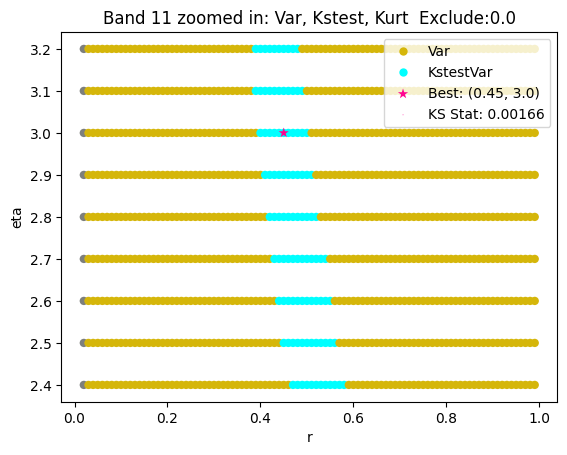

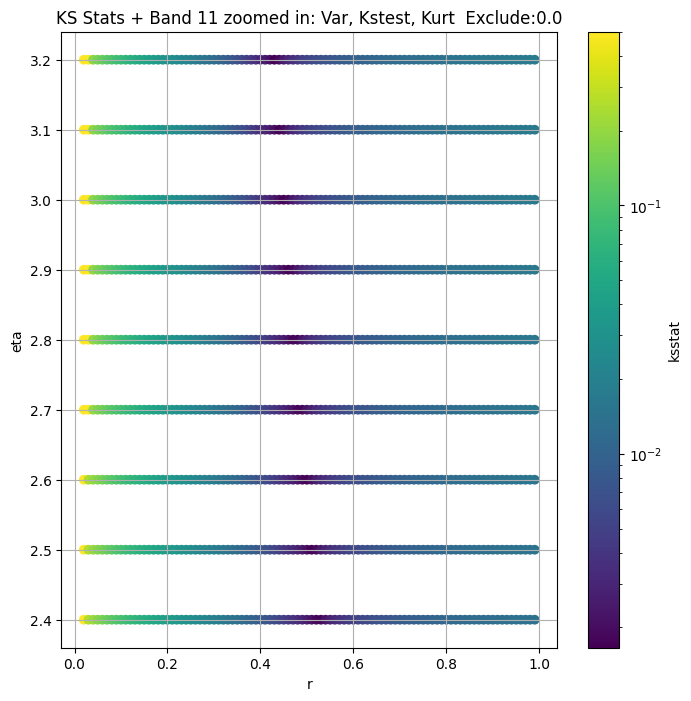

Band 14


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + 100 = 175, ksstat: 0.003271028797165461, var: 1.064462661743164


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + 75 = 150, ksstat: 0.0030019376071725497, var: 1.0716170072555542


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + 50 = 125, ksstat: 0.002733012329017499, var: 1.0792243480682373


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + 25 = 100, ksstat: 0.002545057425834713, var: 1.0874018669128418


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + 0 = 75, ksstat: 0.0025513204902495312, var: 1.0963951349258423


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + -25 = 50, ksstat: 0.0025723031719968037, var: 1.1066182851791382


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + -50 = 25, ksstat: 0.002581079472467218, var: 1.118590235710144


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
band 14, 75.0 + -75 = 0, ksstat: 0.003290582980884027, var: 1.1383591890335083
Number of samples: 100000, Without approximation : 162180.0


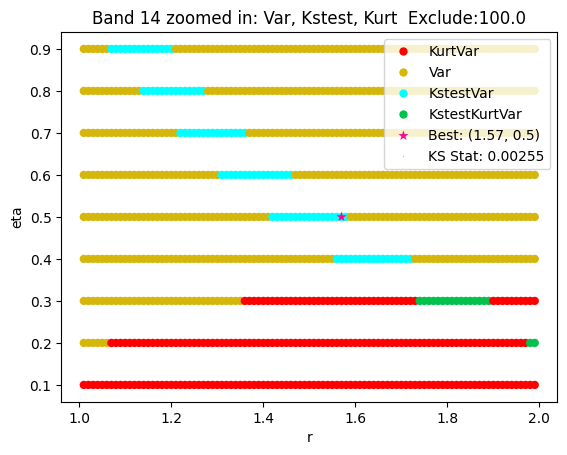

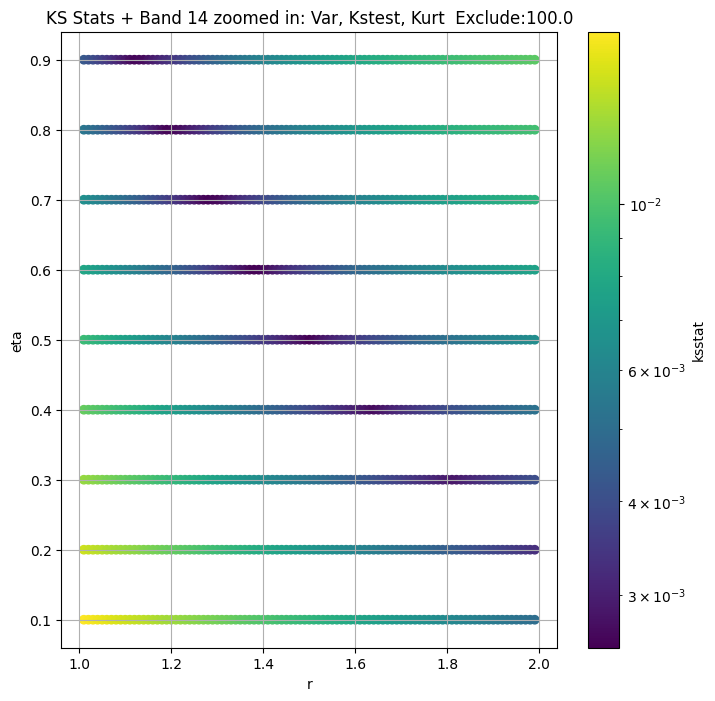

Band 17


  0%|          | 0/980 [00:00<?, ?it/s]

Finding Minimum after computing 980 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.0028868510212733955, var: 0.6045307517051697


  0%|          | 0/980 [00:00<?, ?it/s]

Finding Minimum after computing 980 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.0023982755021541013, var: 0.6095495820045471


  0%|          | 0/980 [00:00<?, ?it/s]

Finding Minimum after computing 980 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.0018674390143901265, var: 0.6151584386825562


  0%|          | 0/980 [00:00<?, ?it/s]

Finding Minimum after computing 980 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.001250965697148776, var: 0.6218412518501282


  0%|          | 0/980 [00:00<?, ?it/s]

Finding Minimum after computing 980 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.0007729102014857048, var: 0.6329777240753174
Number of samples: 100000, Without approximation : 257580.0


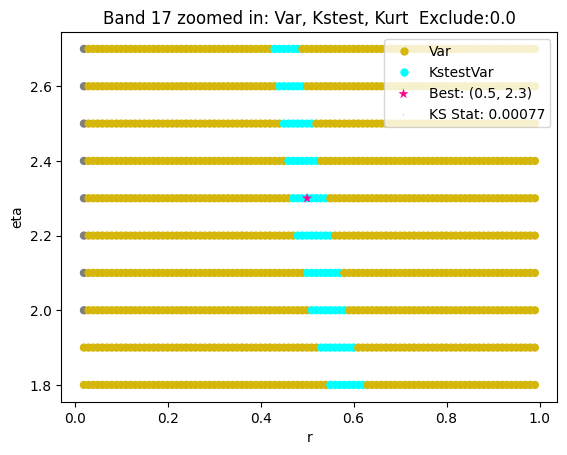

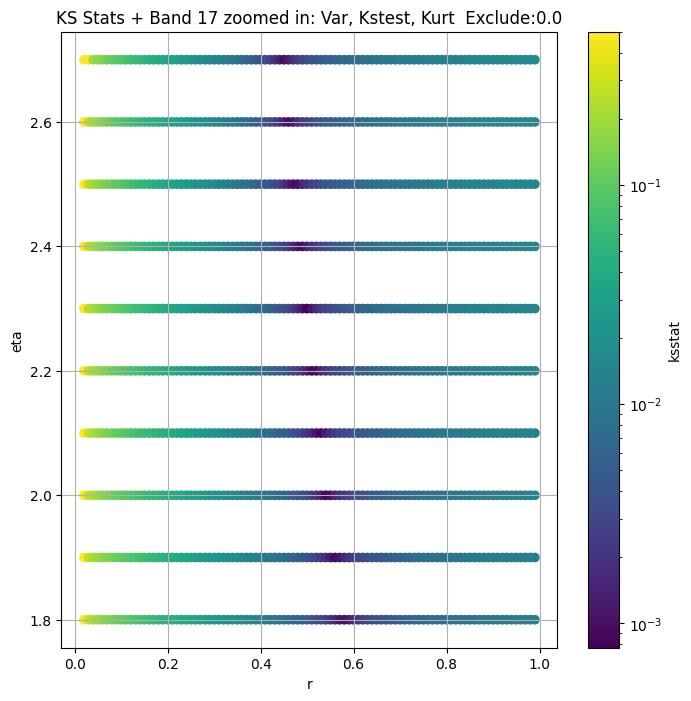

Band 20


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0022751443391691994, var: 0.29914042353630066


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.0018401730124699076, var: 0.30152013897895813


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.001401775201682609, var: 0.3040996193885803


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0010496259241781214, var: 0.3069823980331421


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0007440429456163633, var: 0.3104153275489807


  0%|          | 0/900 [00:00<?, ?it/s]

Finding Minimum after computing 900 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0010455006795150323, var: 0.3162537217140198
Number of samples: 100000, Without approximation : 381600.0


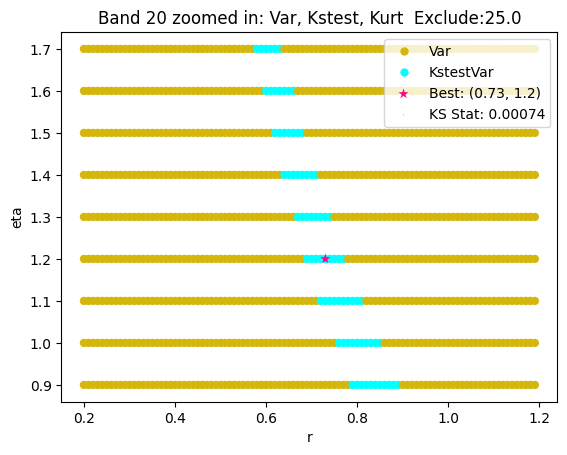

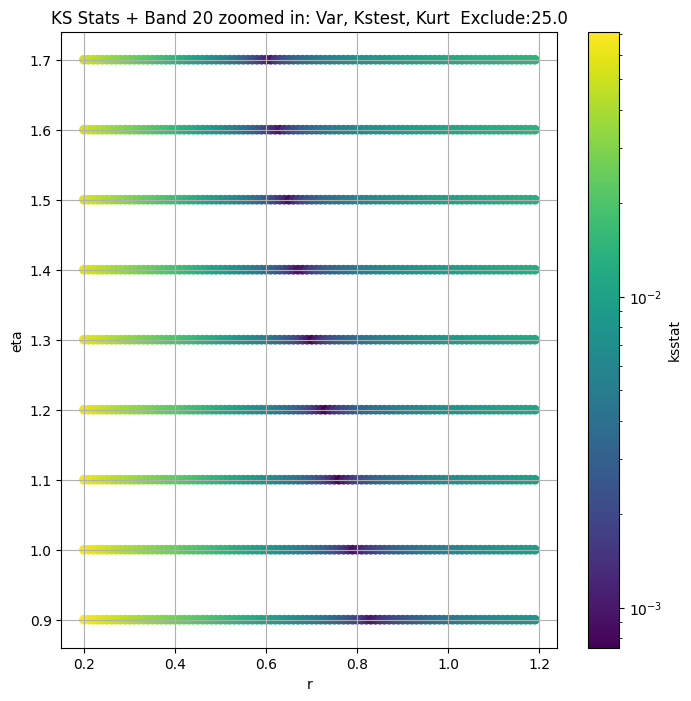

Band 23


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0024216286576064228, var: 0.13811829686164856


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0019667556928668686, var: 0.13928405940532684


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0015652423369223456, var: 0.14056846499443054


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.0014968512161204761, var: 0.1420164555311203


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0014812536855624558, var: 0.1437525451183319


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0015993530539936407, var: 0.14671510457992554
Number of samples: 100000, Without approximation : 610560.0


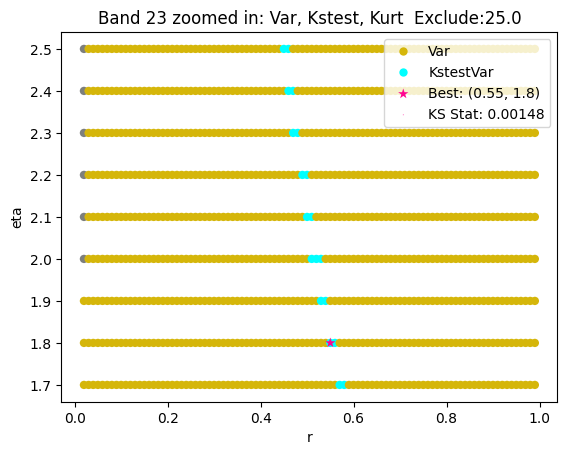

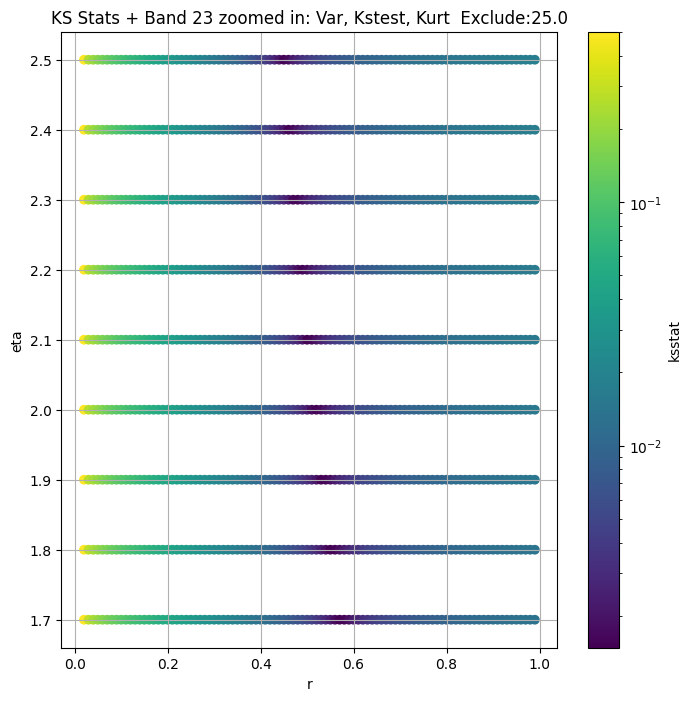

Band 26


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + 100 = 150, ksstat: 0.002789364675350514, var: 0.05314307659864426


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + 75 = 125, ksstat: 0.002296924681440937, var: 0.053636595606803894


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + 50 = 100, ksstat: 0.0017866125106242858, var: 0.05417659506201744


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + 25 = 75, ksstat: 0.0013174406609094413, var: 0.054781343787908554


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + 0 = 50, ksstat: 0.0008588244962439706, var: 0.055479567497968674


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + -25 = 25, ksstat: 0.0009411050082994421, var: 0.056372854858636856


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 26, 50.0 + -50 = 0, ksstat: 0.002414445115326319, var: 0.058341268450021744
Number of samples: 100000, Without approximation : 973080.0


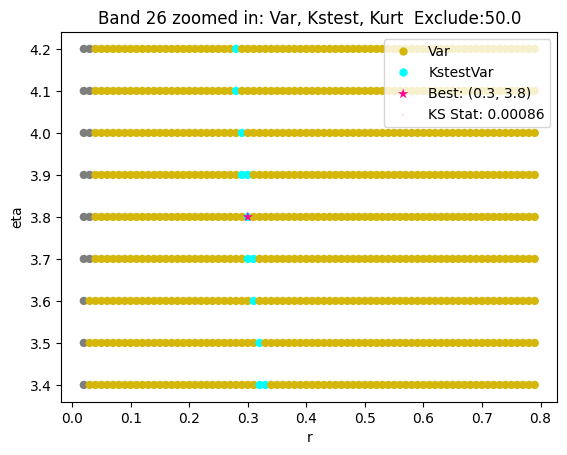

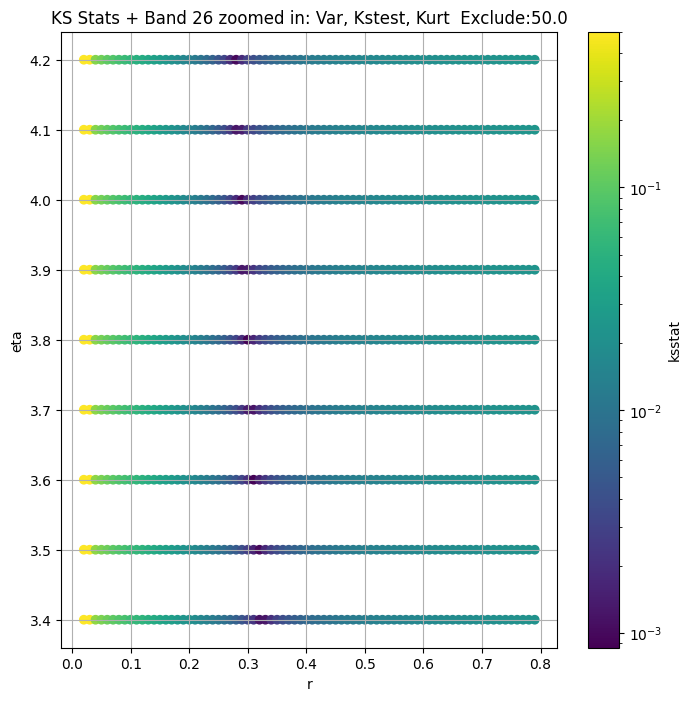

Band 29


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + 100 = 175, ksstat: 0.002697915437222753, var: 0.015031353570520878


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + 75 = 150, ksstat: 0.0022030319004648913, var: 0.015212967991828918


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + 50 = 125, ksstat: 0.001987102284107256, var: 0.015417845919728279


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + 25 = 100, ksstat: 0.002068462700706125, var: 0.015654800459742546


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + 0 = 75, ksstat: 0.0015641391410212216, var: 0.015939388424158096


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + -25 = 50, ksstat: 0.0034188591463372164, var: 0.01630329340696335


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + -50 = 25, ksstat: 0.004281754322528433, var: 0.016813578084111214


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 29, 75.0 + -75 = 0, ksstat: 0.010958115528741708, var: 0.018183842301368713
Number of samples: 100000, Without approximation : 1376940.0


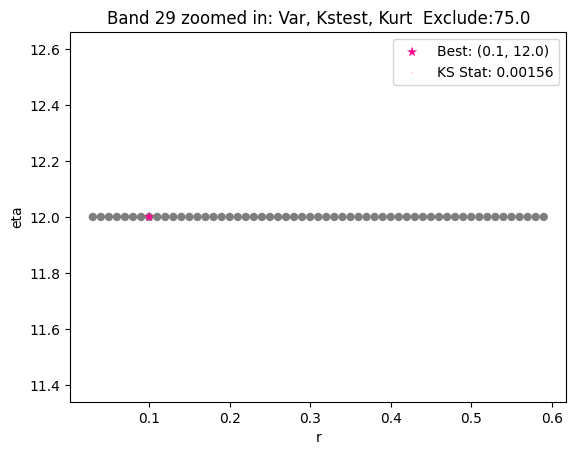

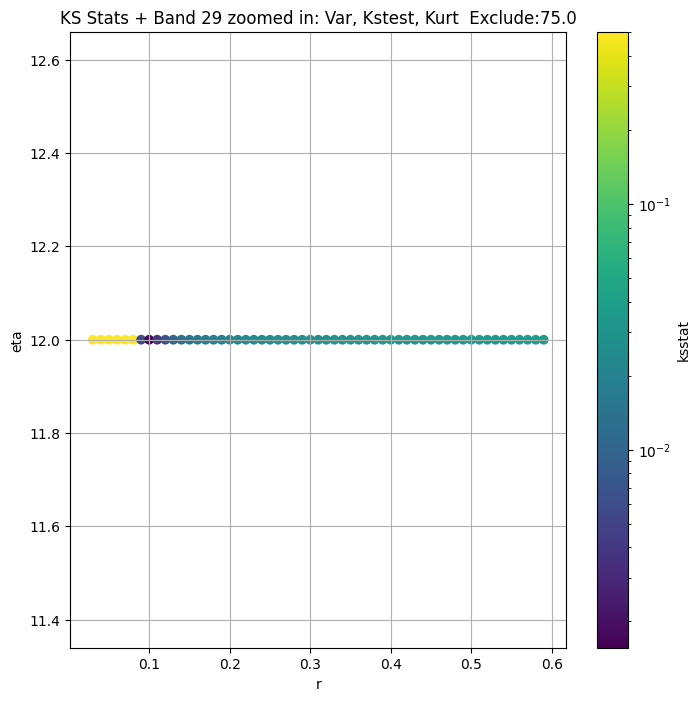

Band 32


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + 100 = 125, ksstat: 0.003477990312361033, var: 0.001423628069460392


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + 75 = 100, ksstat: 0.003029546039719312, var: 0.0014347125543281436


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + 50 = 75, ksstat: 0.0025455959438490175, var: 0.0014469049638137221


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + 25 = 50, ksstat: 0.002018053873728068, var: 0.001460568280890584


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + 0 = 25, ksstat: 0.0014780986586451772, var: 0.0014767431421205401


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 32, 25.0 + -25 = 0, ksstat: 0.0015541262001176892, var: 0.0015016715042293072
Number of samples: 100000, Without approximation : 419760.0


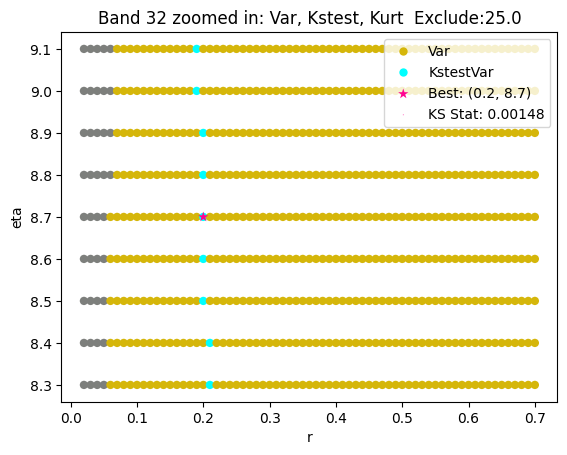

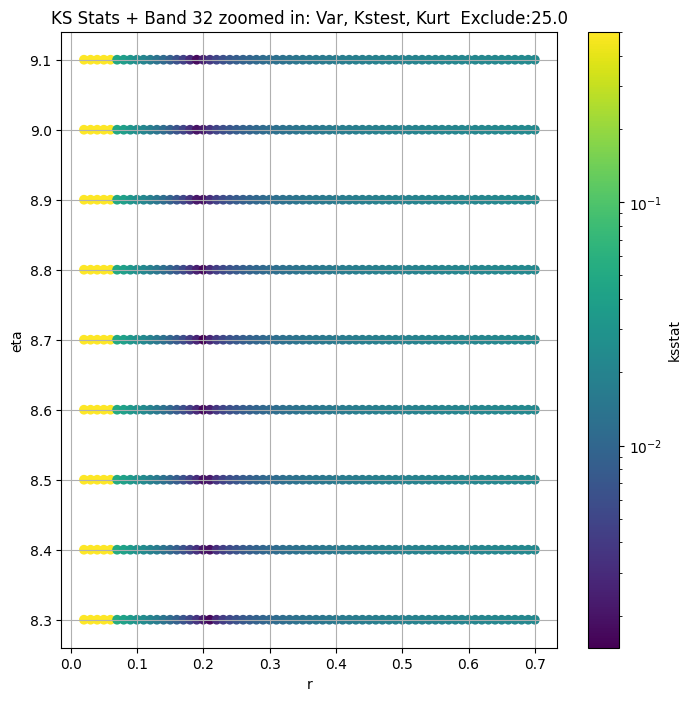

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     12.612577  11.997124  13.256687   1.683772    1.216708    2.278544   
5      6.771047   6.442859   7.115182   1.673940    1.145577    2.416164   
8      3.703258   3.524485   3.887768   1.670122    1.185903    2.265765   
11     2.096400   1.990466   2.207998   2.008084    1.229830    3.563033   
14     1.138359   1.082433   1.197961   1.909717    1.181973    3.535631   
17     0.632978   0.601389   0.666091   1.925273    1.244871    3.354832   
20     0.316254   0.300020   0.334030   2.323948    1.348187    7.316415   
23     0.146715   0.139002   0.155042   2.512090    1.532273    5.086997   
26     0.058341   0.054549   0.063335   6.085310    2.217141   24.902412   
29     0.018184   0.016286   0.021421  26.047552    5.259968  114.970770   
32     0.001502   0.001426   0.001581   1.958381    1.283293    4.106231   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           31800.0             0.003710        0.4          3.4   
5           41340.0             0.002315        1.2          0.7   
8           66780.0             0.003071        0.7          2.0   
11         104940.0             0.001673        0.5          2.8   
14         162180.0             0.002568        1.5          0.5   
17         257580.0             0.000773        0.5          2.3   
20         381600.0             0.000783        0.7          1.3   
23         610560.0             0.001494        0.5          2.1   
26         973080.0             0.000859        0.3          3.8   
29        1376940.0             0.001564        0.1         12.0   
32         419760.0             0.001478        0.2          8.7   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.076602e-02                     0.0           12.612577   
5      4.109167e+00                    25.0            6.572597   
8      3.387471e-01                    50.0            3.627510   
11     2.492160e-02                    25.0            2.096400   
14     9.790584e-01                    75.0            1.087402   
17     9.684482e-03                     0.0            0.632978   
20     3.990189e-02                    25.0            0.310415   
23     2.434833e-03                    25.0            0.143753   
26     3.133996e-06                    50.0            0.055480   
29     5.723353e-24                    75.0            0.015939   
32     3.537522e-12                    25.0            0.001477   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.007611          0.003710    0.40       3.4   
5                    0.006675          0.002311    1.14       0.8   
8                    0.005253          0.003057    0.59       2.4   
11                   0.004191          0.001655    0.45       3.0   
14                   0.003371          0.002545    1.57       0.5   
17                   0.002675          0.000773    0.50       2.3   
20                   0.002198          0.000744    0.73       1.2   
23                   0.001738          0.001481    0.55       1.8   
26                   0.001377          0.000859    0.30       3.8   
29                   0.001157          0.001564    0.10      12.0   
32                   0.002096          0.001478    0.20       8.7   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.076602e-02                  0.0       135831  
5     3.640768e+00                 25.0       353164  
8     1.357988e-01                 25.0       190165  
11    1.105133e-02                  0.0       672372  
14    1.015633e+00                

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

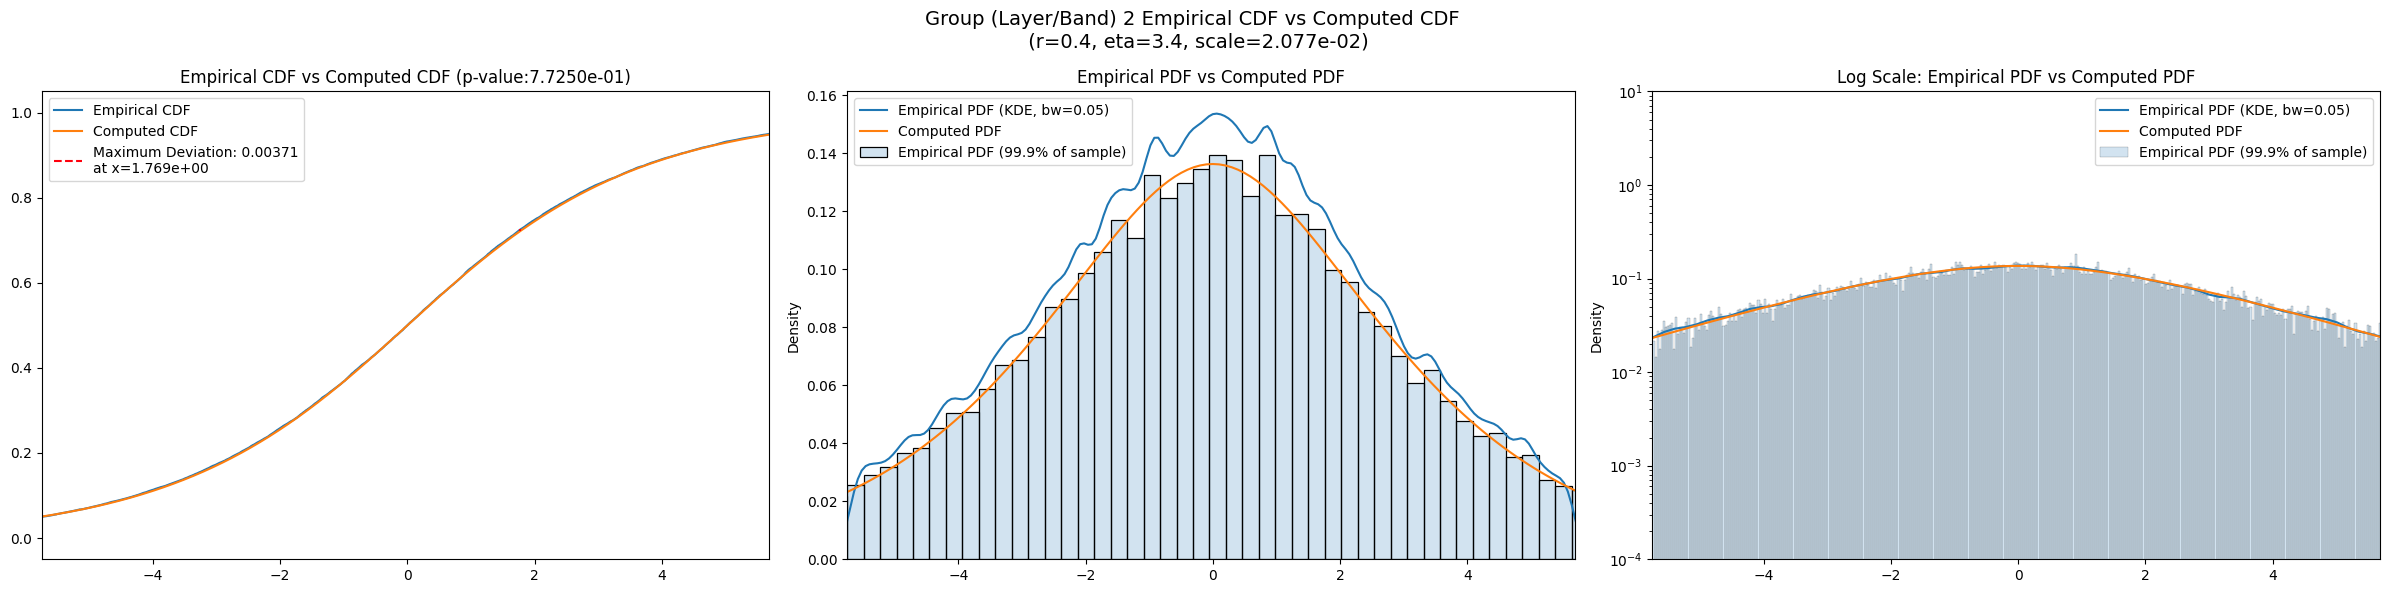

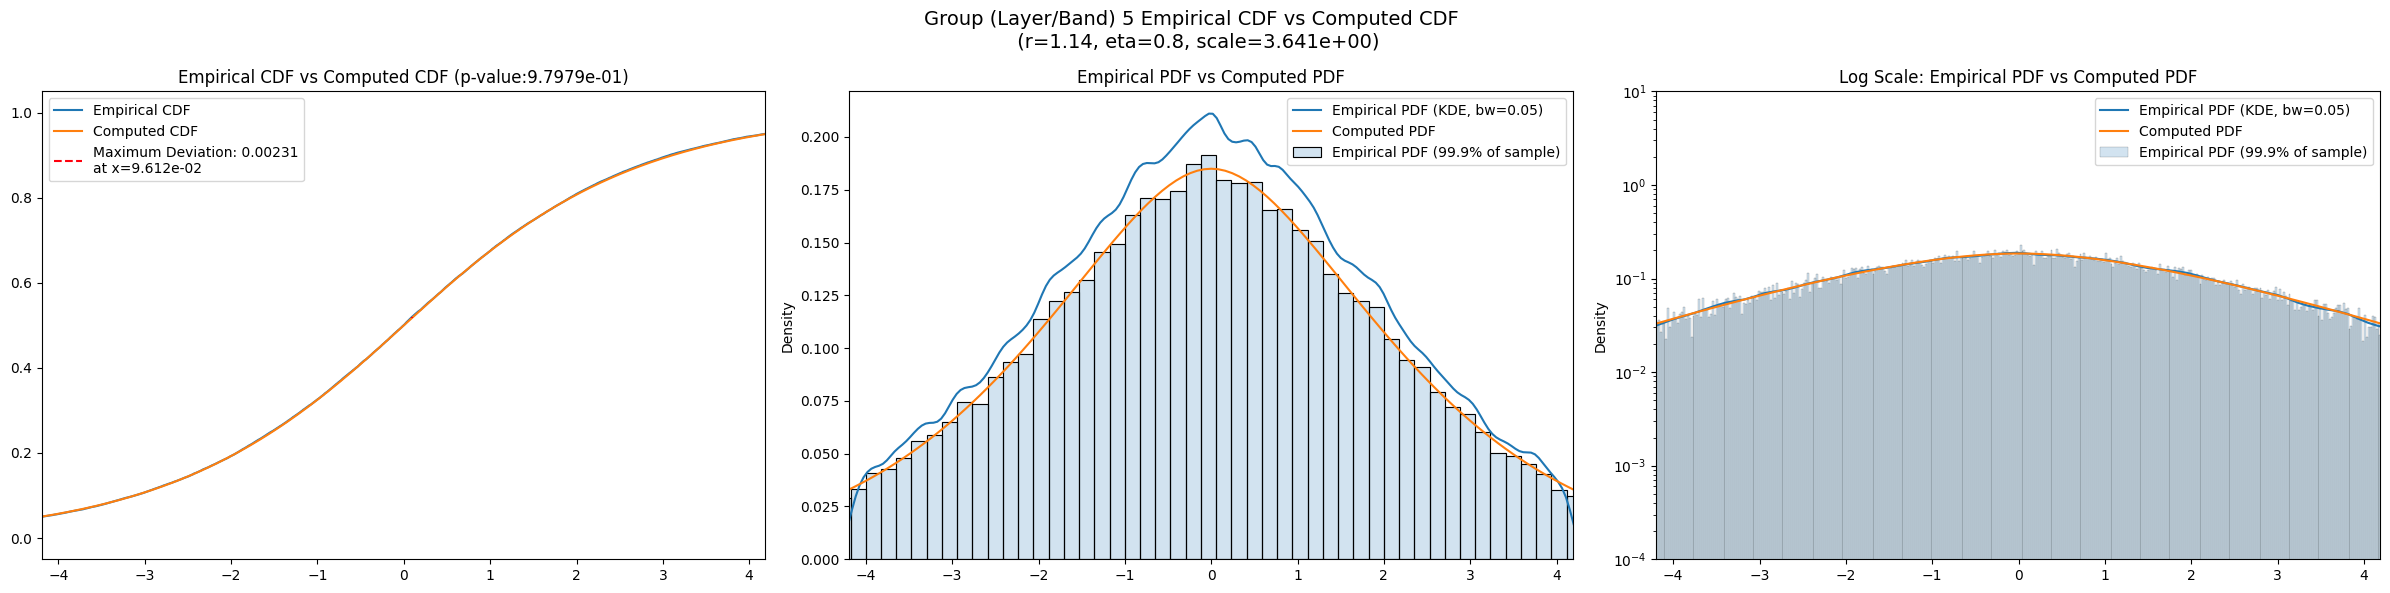

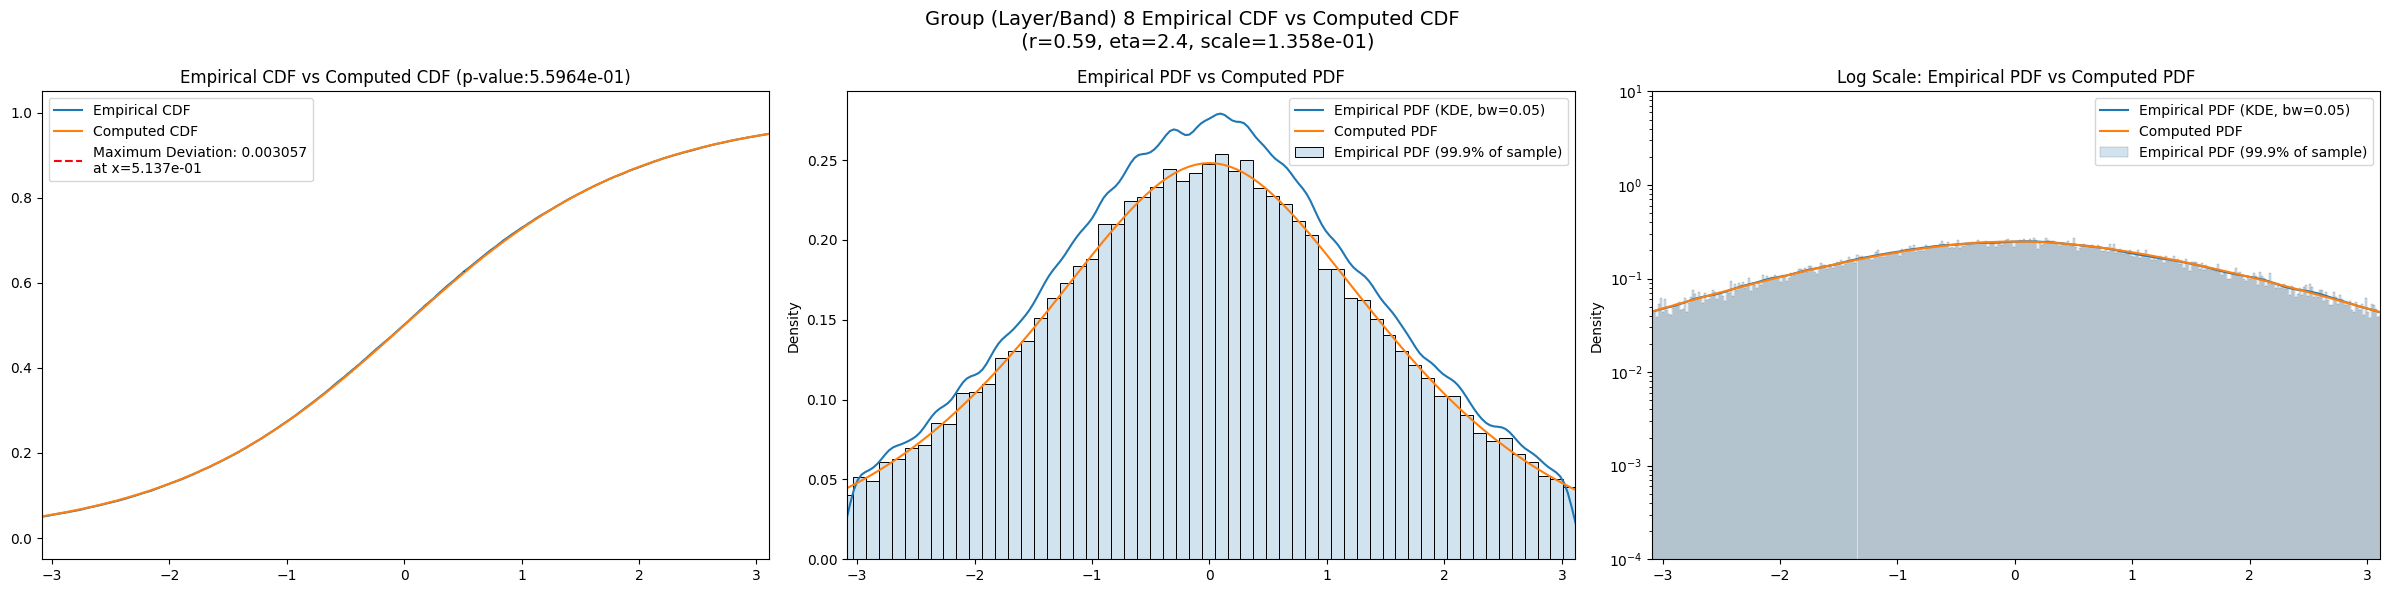

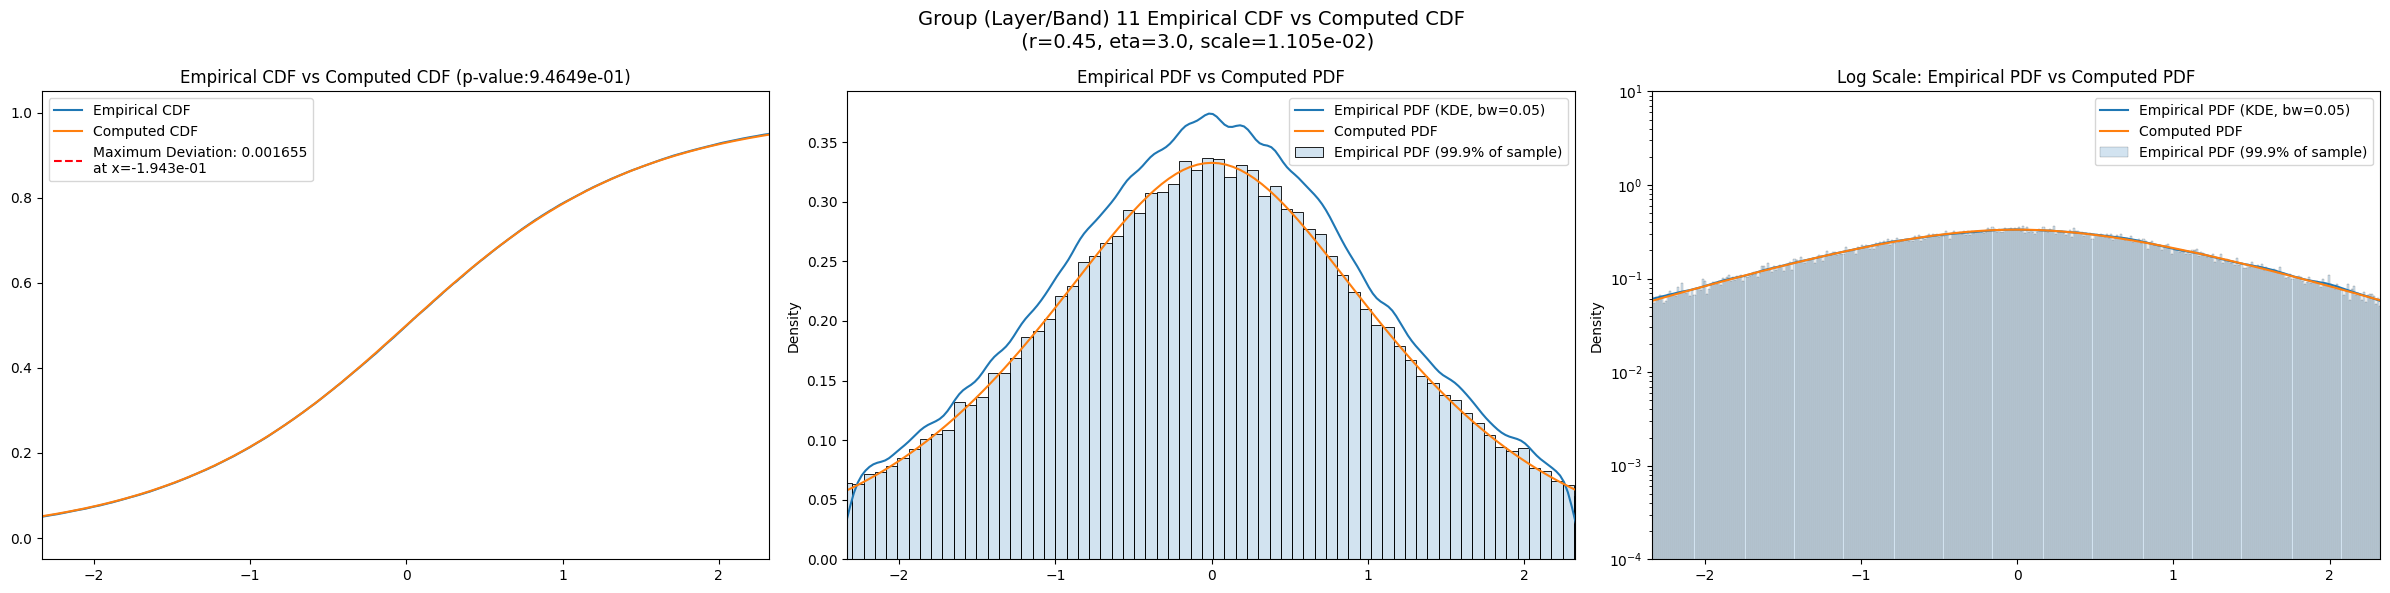

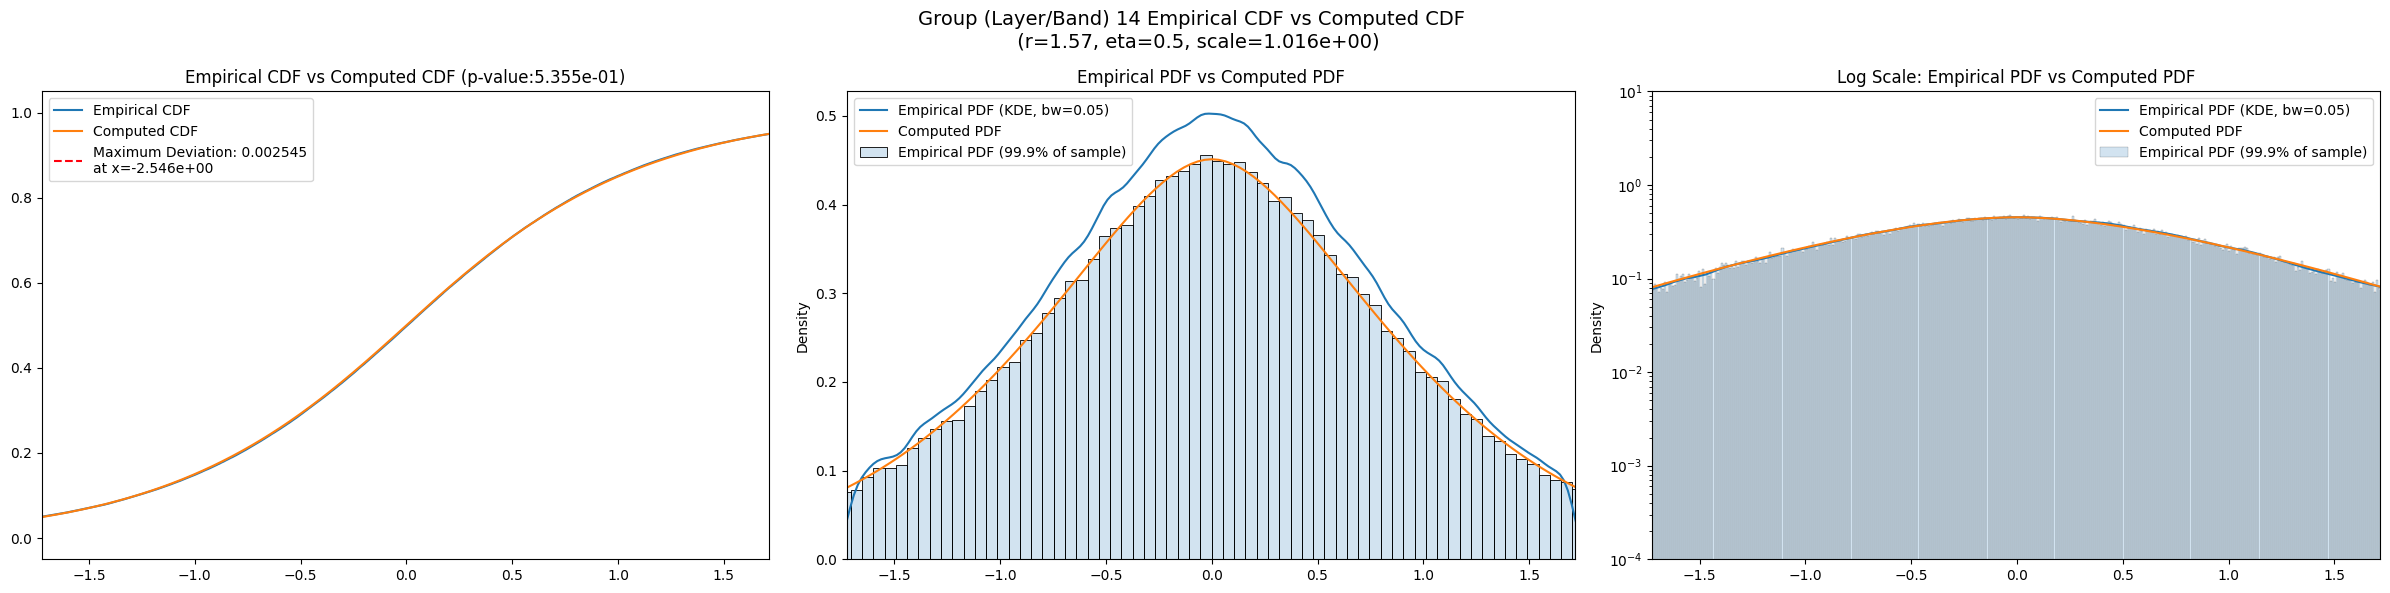

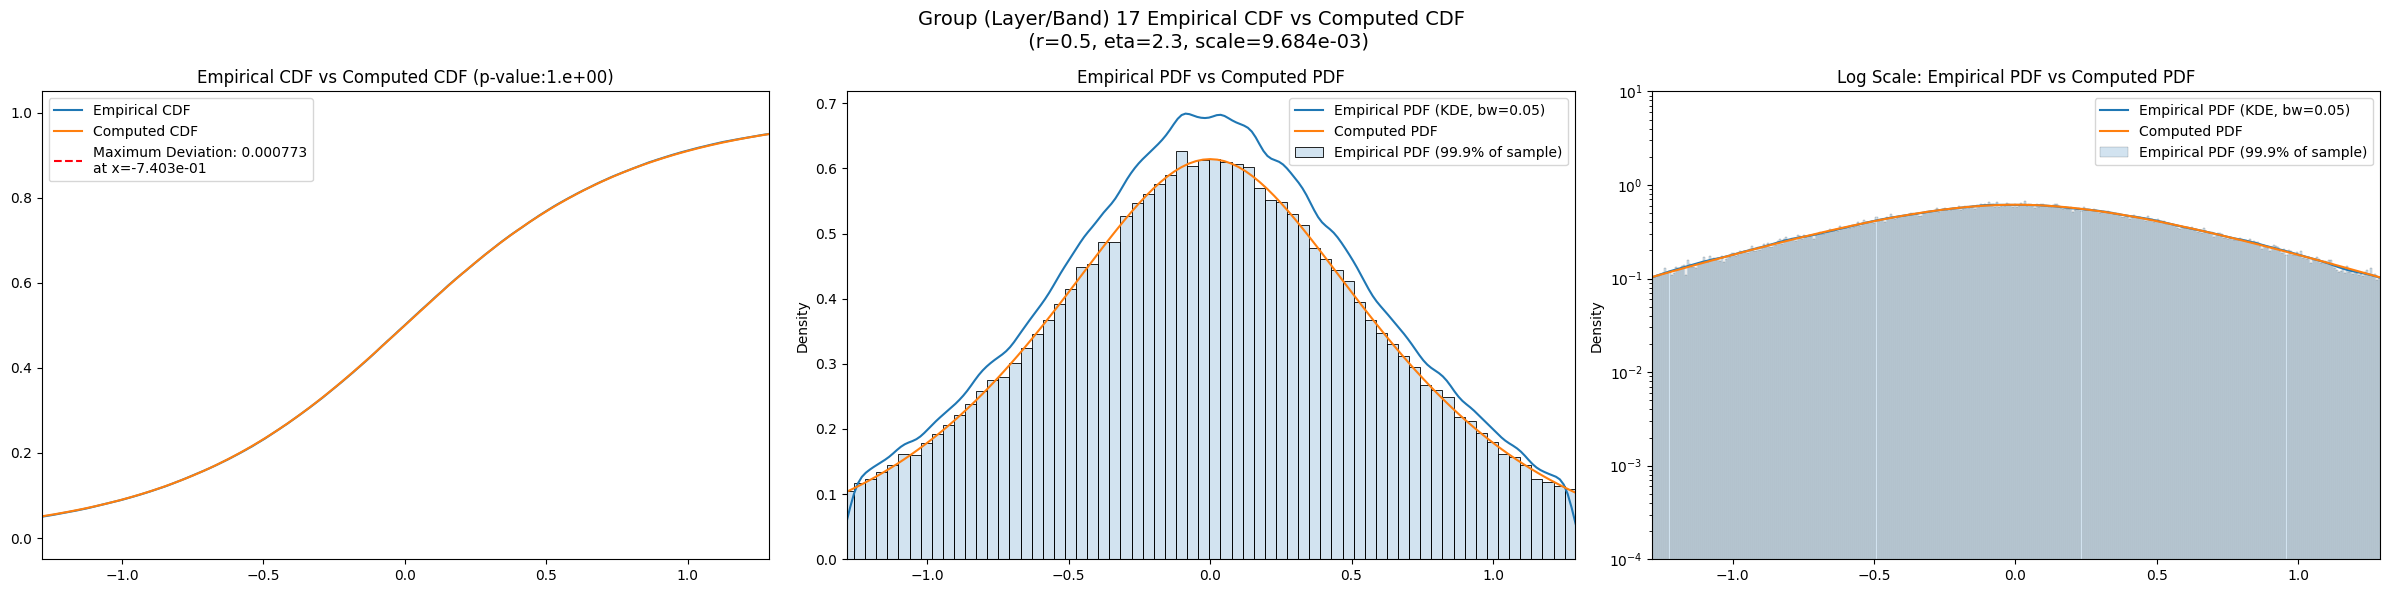

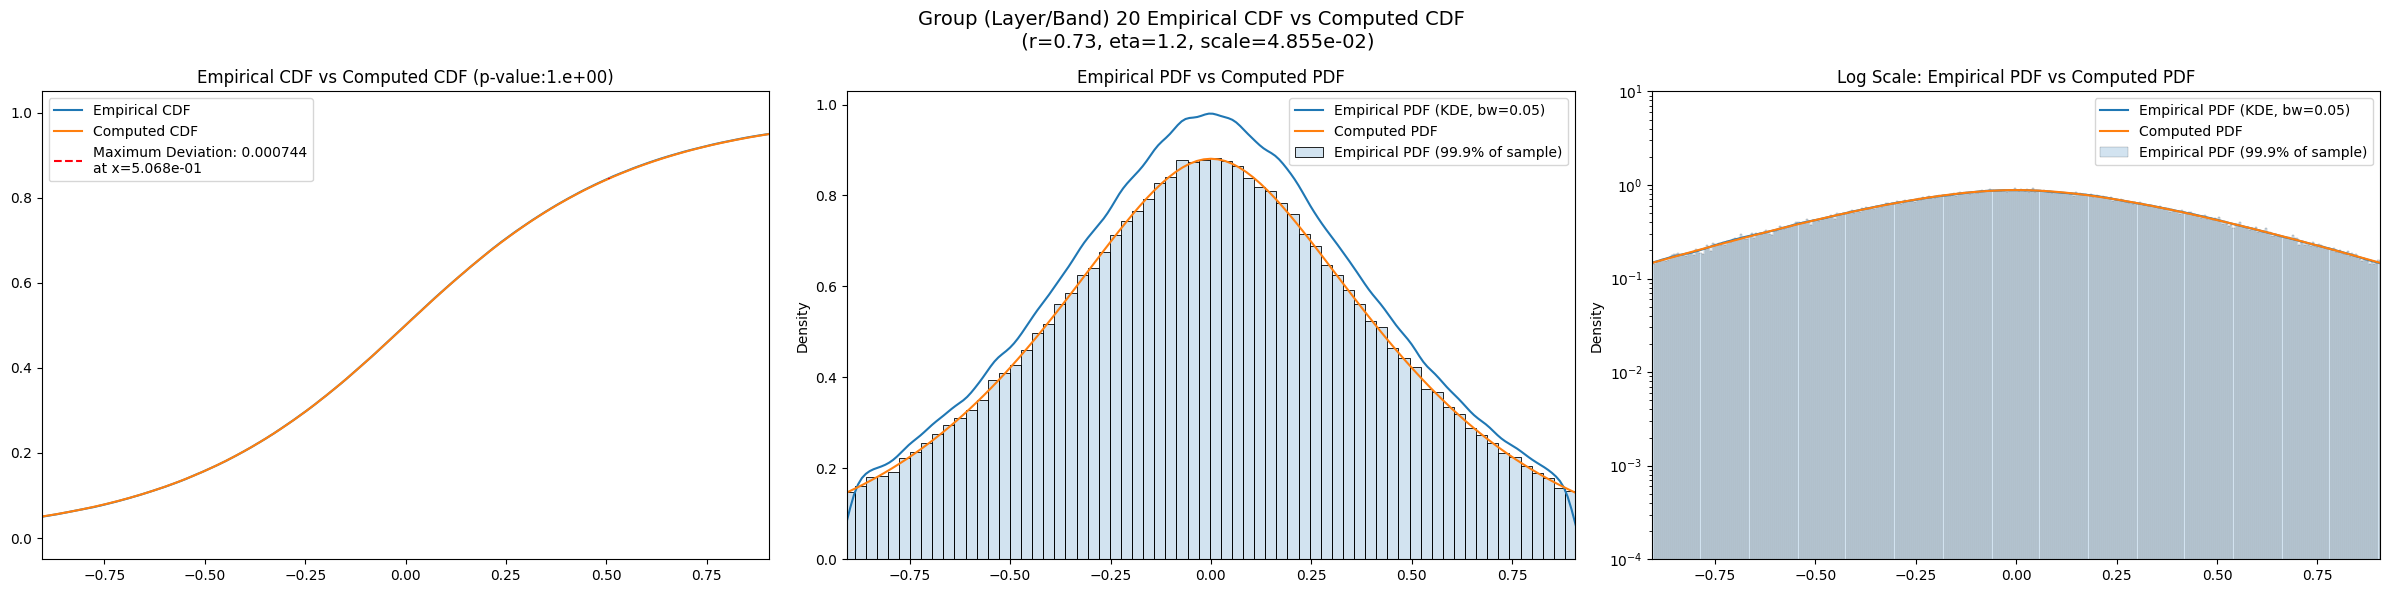

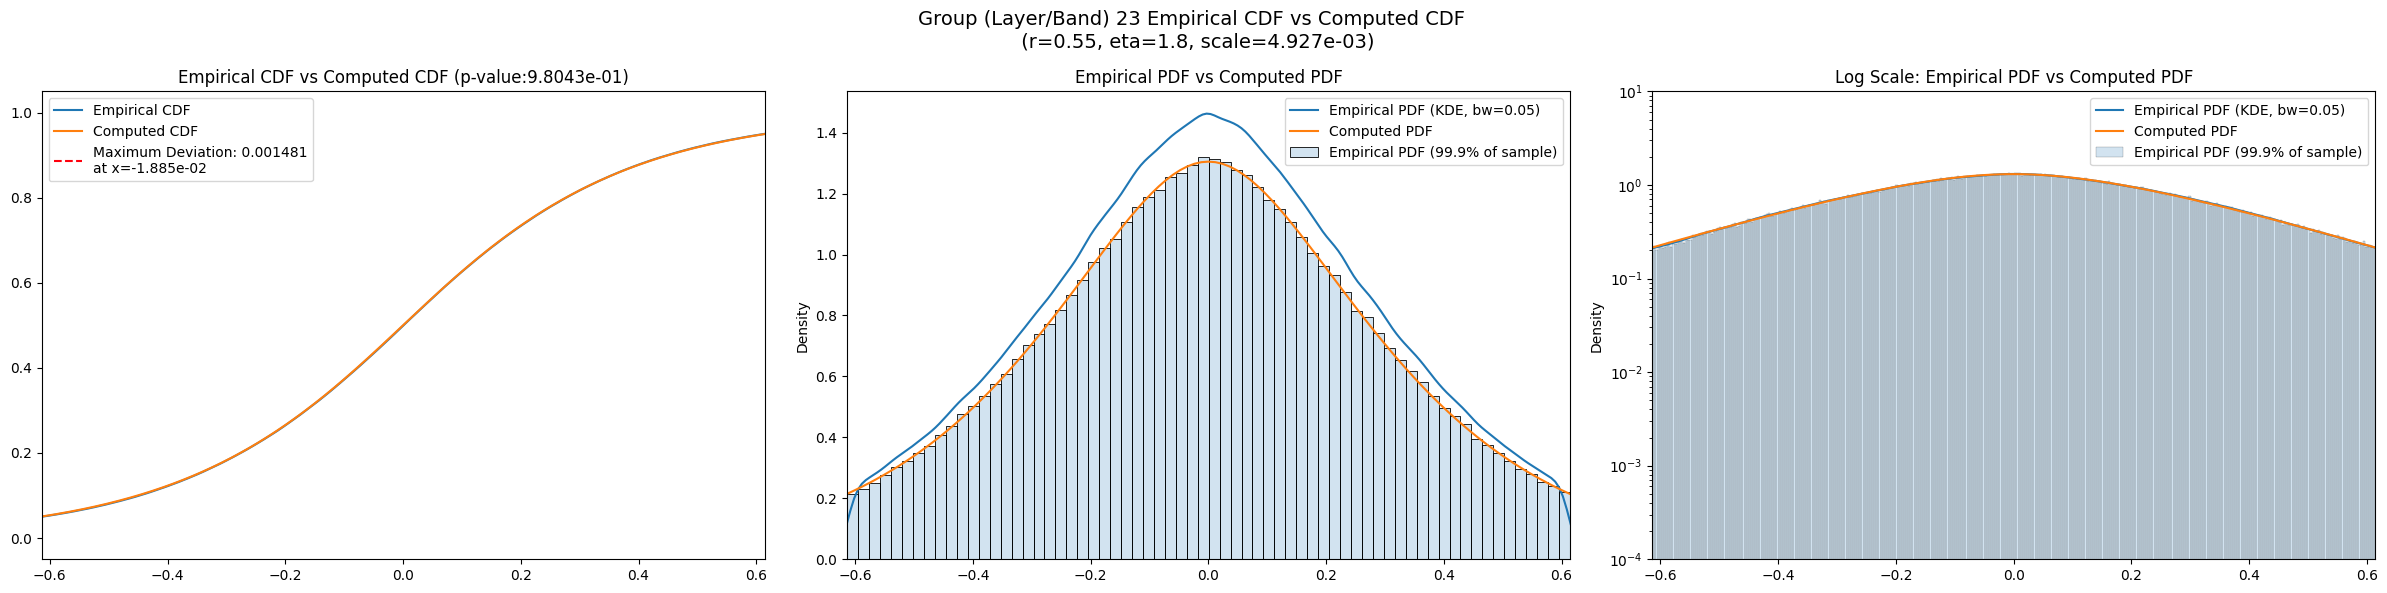

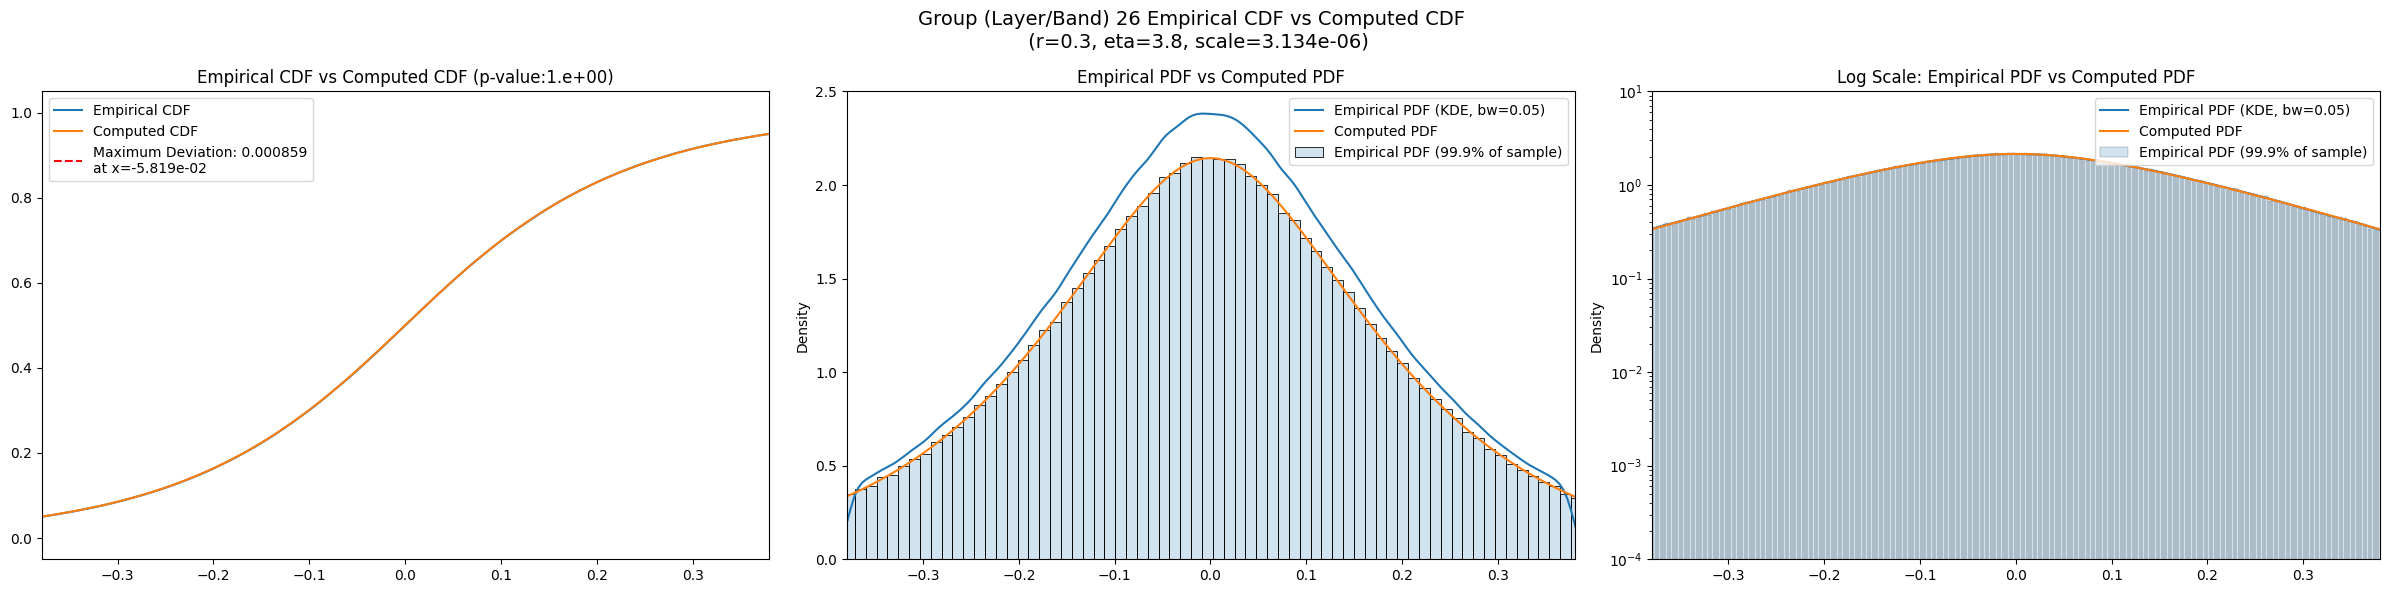

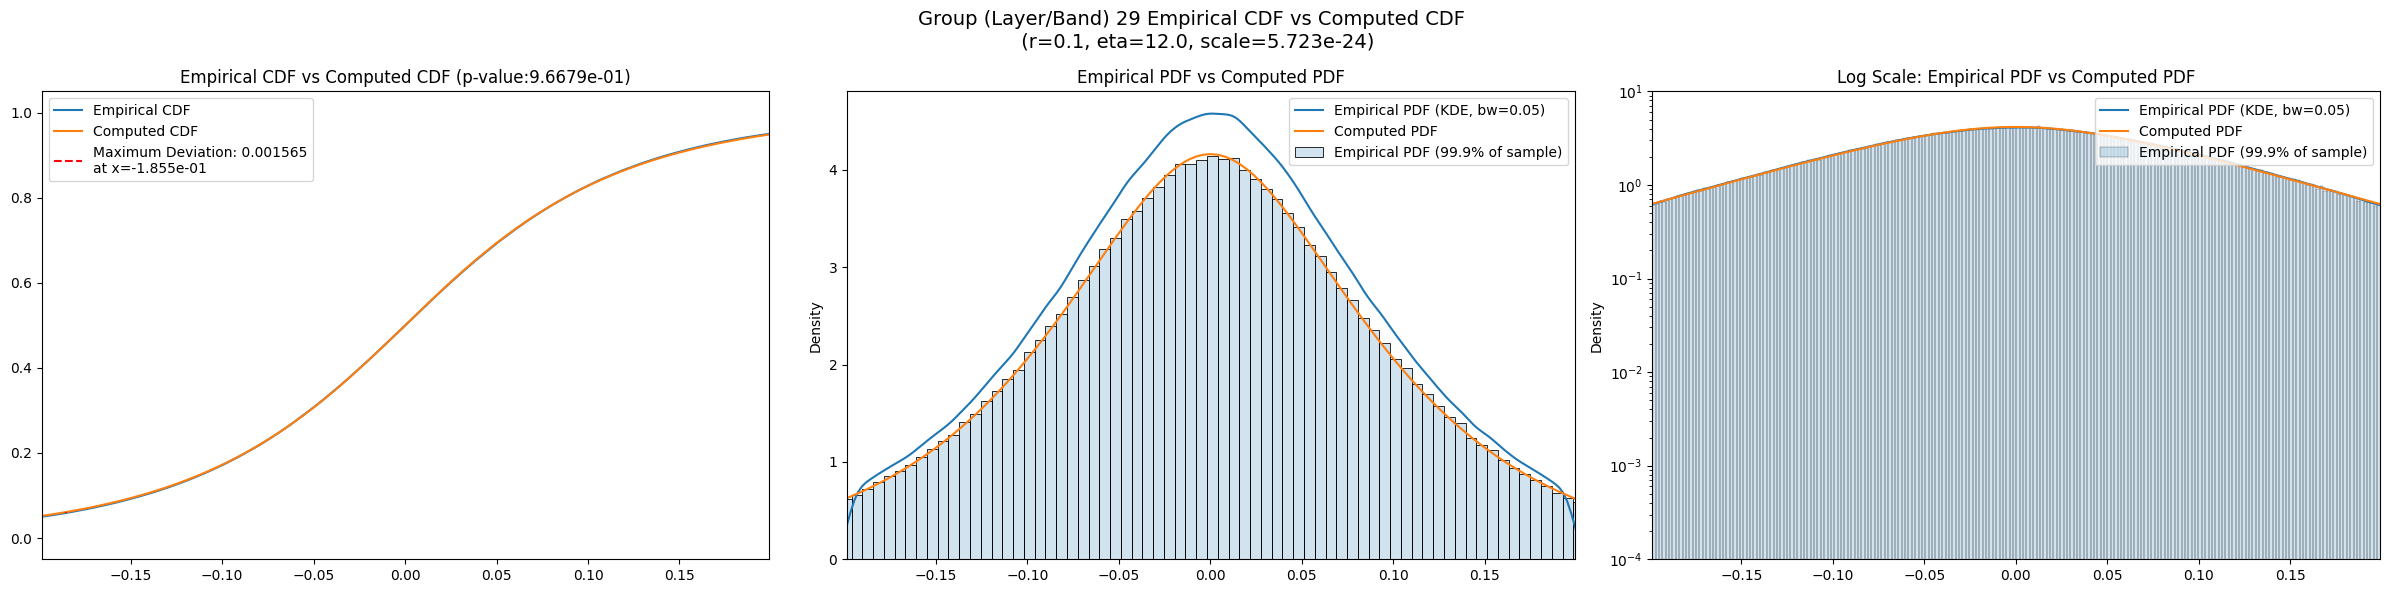

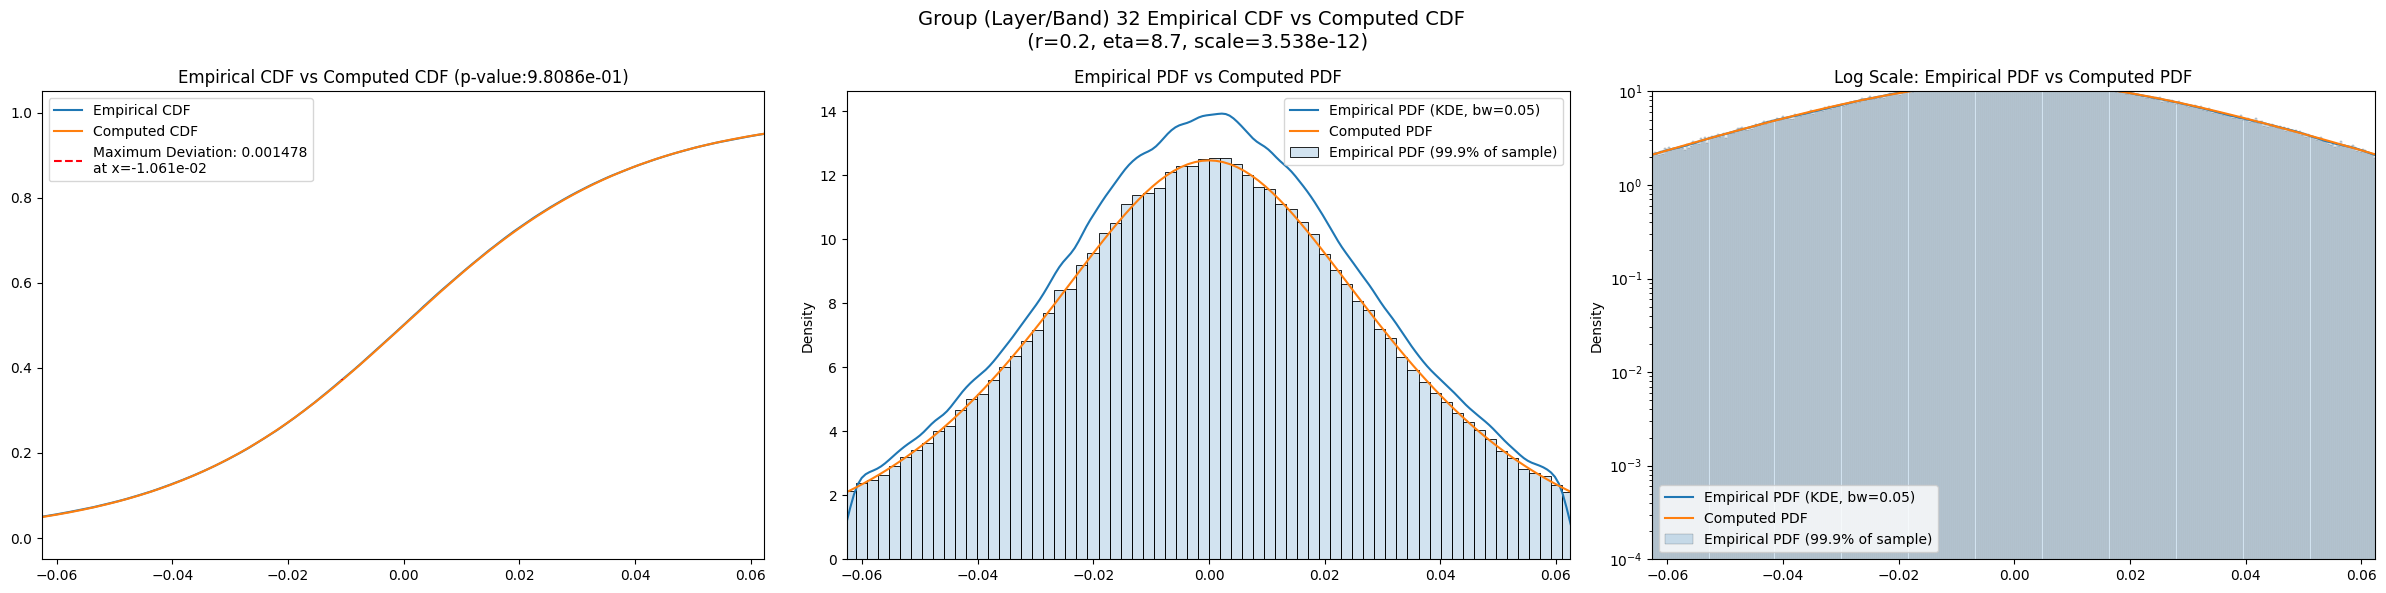

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     12.612577  11.997124  13.256687   1.683772    1.216708    2.278544   
5      6.771047   6.442859   7.115182   1.673940    1.145577    2.416164   
8      3.703258   3.524485   3.887768   1.670122    1.185903    2.265765   
11     2.096400   1.990466   2.207998   2.008084    1.229830    3.563033   
14     1.138359   1.082433   1.197961   1.909717    1.181973    3.535631   
17     0.632978   0.601389   0.666091   1.925273    1.244871    3.354832   
20     0.316254   0.300020   0.334030   2.323948    1.348187    7.316415   
23     0.146715   0.139002   0.155042   2.512090    1.532273    5.086997   
26     0.058341   0.054549   0.063335   6.085310    2.217141   24.902412   
29     0.018184   0.016286   0.021421  26.047552    5.259968  114.970770   
32     0.001502   0.001426   0.001581   1.958381    1.283293    4.106231   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           31800.0             0.003710        0.4          3.4  ...   
5           41340.0             0.002315        1.2          0.7  ...   
8           66780.0             0.003071        0.7          2.0  ...   
11         104940.0             0.001673        0.5          2.8  ...   
14         162180.0             0.002568        1.5          0.5  ...   
17         257580.0             0.000773        0.5          2.3  ...   
20         381600.0             0.000783        0.7          1.3  ...   
23         610560.0             0.001494        0.5          2.1  ...   
26         973080.0             0.000859        0.3          3.8  ...   
29        1376940.0             0.001564        0.1         12.0  ...   
32         419760.0             0.001478        0.2          8.7  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           3.198530              0.014880          1.517320e-06   
5           2.372410              0.013012          1.649690e-06   
8           1.746430              0.013531          4.758190e-11   
11          1.315900              0.012833          1.926580e-15   
14          0.970979              0.013318          2.041180e-25   
17          0.721698              0.014092          7.336650e-45   
20          0.505674              0.014387          4.881290e-69   
23          0.342048              0.014896         4.181190e-118   
26          0.209743              0.016196         3.775580e-222   
29          0.109517              0.017132          0.000000e+00   
32          0.035087              0.014020          4.247870e-72   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.859320             0.018199         1.402270e-09  2.309200   
5          2.097440             0.018105         3.352490e-12  1.694900   
8          1.560780             0.018930         3.225610e-21  1.255870   
11         1.163770             0.017656         7.599720e-29  0.934937   
14         0.862850             0.018225         3.184560e-47  0.693391   
17         0.635307             0.015916         4.169210e-57  0.510918   
20         0.446114             0.015323         2.938650e-78  0.358713   
23         0.301620             0.015321        6.361510e-125  0.243474   
26         0.184919             0.013979        1.329260e-165  0.148906   
29         0.096336             0.013678        3.424620e-224  0.077685   
32         0.031131             0.017125        2.316510e-107  0.024986   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.020124   1.284160e-11              0.772502  
5          0.020490   1.652270e

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003710                 0.007611          0.003710   
5                0.002315                 0.006675          0.002311   
8                0.003071                 0.005253          0.003057   
11               0.001673                 0.004191          0.001655   
14               0.002568                 0.003371          0.002545   
17               0.000773                 0.002675          0.000773   
20               0.000783                 0.002198          0.000744   
23               0.001494                 0.001738          0.001481   
26               0.000859                 0.001377          0.000859   
29               0.001564                 0.001157          0.001564   
32               0.001478                 0.002096          0.001478   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.014880             0.018199       0.020124  
5                 0.013012             0.018105       0.020490  
8                 0.013531             0.018930       0.020387  
11                0.012833             0.017656       0.019751  
14                0.013318             0.018225       0.020215  
17                0.014092             0.015916       0.018834  
20                0.014387             0.015323       0.018554  
23                0.014896             0.015321       0.017931  
26                0.016196             0.013979       0.016442  
29                0.017132             0.013678       0.015212  
32                0.014020             0.017125       0.018909

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2              12.612577          0.003710    0.40       3.4  2.076602e-02   
5               6.572597          0.002311    1.14       0.8  3.640768e+00   
8               3.627510          0.003057    0.59       2.4  1.357988e-01   
11              2.096400          0.001655    0.45       3.0  1.105133e-02   
14              1.087402          0.002545    1.57       0.5  1.015633e+00   
17              0.632978          0.000773    0.50       2.3  9.684482e-03   
20              0.310415          0.000744    0.73       1.2  4.855299e-02   
23              0.143753          0.001481    0.55       1.8  4.926779e-03   
26              0.055480          0.000859    0.30       3.8  3.133996e-06   
29              0.015939          0.001564    0.10      12.0  5.723353e-24   
32              0.001477          0.001478    0.20       8.7  3.537522e-12   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    25.0  
8                    25.0  
11                    0.0  
14                  100.0  
17                    0.0  
20                   25.0  
23                   25.0  
26                   50.0  
29                   75.0  
32                   25.0